# <font color="blue">1. Import Libraries</font>

* Import the required libraries.

In [6]:
import math
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

from datetime import date
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import Normalizer

In [7]:
pd.options.display.max_columns = None # To display all the columns of a Dataframe.
warnings.filterwarnings('ignore') # Ignore any warnings and do not show them in the cell output.

----

# <font color="blue">2. Import Dataset</font>

* Import the dataset downloaded from the [Kaggle Dataset](https://www.kaggle.com/rohitrox/healthcare-provider-fraud-detection-analysis) and store in DataFrames.

In [ ]:
%%time
'''
Dataset
'''
dataProvider = pd.read_csv('Data/Train-1542865627584.csv') # Mapping Dataset
dataBeneficiary = pd.read_csv('Data/Train_Beneficiarydata-1542865627584.csv') # Beneficiary Dataset
dataInpatient = pd.read_csv('Data/Train_Inpatientdata-1542865627584.csv') # Inpatient Dataset
dataOutpatient = pd.read_csv('Data/Train_Outpatientdata-1542865627584.csv') # Outpatient Dataset

Wall time: 2.17 s


----

# <font color="blue">3. Exploratory Data Analysis (EDA)</font>

* We will do EDA on each Dataset one by one.

## <font color="blue">3.1. Utility Functions</font>

* Creating some utility functions that can be reused in plotting.

In [31]:
def getPlotLegends(labels):
    '''
    Forms a dictionary containing the color name as keys and matplotlib patches as their values.
    The returned value can be used to display legends in a plot.
    
    Parameter:
    ---------
    labels: list
        List containing the labels for the legends to be shown in a plot.
    '''
    
    dictPatch = dict() # Resultant dictionary to contain the labels information
    
    # For each labels, get a color value from the seaborn 'muted' color palette and form an mpatch
    for i in range(len(labels)):
        colorVal = sns.color_palette('muted')[i]
        dictPatch[colorVal] = mpatches.Patch(color=colorVal, label=labels[i])
    
    return dictPatch

In [32]:
def countPlot(figsize, title, xlabel, ylabel, data, feature, legends=[], showLegend=False, showTop=True, firstK=0, 
              **kwargs):
    '''
    Function to plot the Count Plot using seaborn for the categorical features.
    
    Parameters
    ----------
    figsize: tuple
        width and height of the figure.
    title: str
        Title of the Plot.
    xlabel: str
        Label to show on the x-axis.
    ylabel: str
        Label to show on the y-axis.
    data: pandas.core.frame.DataFrame
        DataFrame for which the plot is to be shown.
    feature: str
        Feature for which the plot is to be shown.
    legends: list
        List of strings for the legends to be shown.
    showLegends: bool
        Boolean flag to indicate whether to show the legends or not.
    showTop: bool
        Boolean flag to indicate whether to show the top k distribution or bottom k distribution.
    firstK: int
        Show the first k categories in the distribution (top or bottom)
    **kwargs: Keyword Arguments
    '''
    
    plt.figure(figsize=figsize) # Define the plot area's figure size
    sns.set_style('whitegrid') # Set the backgound of the plot as 'whitegrid'
    
    # If firstK is not zero, prepare the first k categories to be shown based on showTop flag
    if firstK != 0:
        if showTop == True:
            order = data[feature].value_counts().head(firstK).index # Top 'k' categories' count
        else:
            order = data[feature].value_counts().tail(firstK).index # Bottom 'k' categories count
    
    # If Legends need to be shown in the figure.
    if showLegend:
        dictLegends = getPlotLegends(legends) # Get the legend's color palette
        
        # If all categories has to be considered in the Count Plot
        if firstK == 0:
            
            # If hue is required to separate the plot based on the class label
            if 'hue' in kwargs.keys():
                ax = sns.countplot(data=data, x=feature, palette=dictLegends.keys(), hue=kwargs['hue'])
            else:
                ax = sns.countplot(data=data, x=feature, palette=dictLegends.keys())
                
        else:
            
            # If hue is required to separate the plot based on the class label
            if 'hue' in kwargs.keys():
                ax = sns.countplot(data=data, x=feature, palette=dictLegends.keys(), order=order, hue=kwargs['hue'])
            else:
                ax = sns.countplot(data=data, x=feature, palette=dictLegends.keys(), order=order)
                
        # Plot the legends
        plt.legend(handles=dictLegends.values(), bbox_to_anchor=(1,1), loc='upper right')
        
    else:
        
        # If all categories has to be considered in the Count Plot
        if firstK == 0:
            
            # If hue is required to separate the plot based on the class label
            if 'hue' in kwargs.keys():
                ax = sns.countplot(data=data, x=feature, hue=kwargs['hue'])
            else:
                ax = sns.countplot(data=data, x=feature)
                
        else:
            
            # If hue is required to separate the plot based on the class label
            if 'hue' in kwargs.keys():
                ax = sns.countplot(data=data, x=feature, order=order, hue=kwargs['hue'])
            else:
                ax = sns.countplot(data=data, x=feature, order=order)
                
    plt.title(title, fontsize=20) # Title of the Plot
    plt.xlabel(xlabel, fontsize=15) # Label on the x-axis
    plt.ylabel(ylabel, fontsize=15) # Label on the y-axis
    
    # If the x-axis tick labels need to be rotated
    if 'xtickRotate' in kwargs.keys():
        plt.xticks(rotation=kwargs['xtickRotate'])
    
    # Reference: 'seaborn countplot show percentage': https://datascience.stackexchange.com/a/48044
    total = len(data[feature]) # Total number of rows in the feature
    for p in ax.patches:
        percentage = '{:.2f}%'.format(100 * p.get_height()/total) # Percentage of non-null values in the feature
        x = p.get_x() + p.get_width()/2 - 0.03
        y = p.get_y() + p.get_height()
        
        # If the percentage value label need to be rotated
        if 'annotateRotate' in kwargs.keys():
            ax.annotate(percentage, (x, y), rotation=kwargs['annotateRotate'])
        else:
            ax.annotate(percentage, (x, y))
    
    # Show the plot
    plt.show()

In [33]:
def plotNumFeat(**kwargs):
    '''
    Function to plot different kinds of plot for the numeric features like Density Plot (Histogram/PDF) or
    BoxPlot using seaborn.
    
    Parameters
    ----------
    **kwargs: Keyword Arguments
    '''
    
    # If Density (Histogram/PDF) Plot is required to be shown.
    if (kwargs['type'] == 'Density'):
        
        # If hue is required to separate the plot based on the class label
        if 'hue' in kwargs.keys():
            
            sns.FacetGrid(kwargs['data'], height=kwargs['figureHeight'], hue=kwargs['hue']) \
                .map(sns.distplot, kwargs['feature']) # Plot the Density Plot with hue based on class label.
            plt.legend(['Legitimate Providers', 'Fraud Providers']) # Add legends
            
        else:
            
            # Plot the Density Plot without a hue based on class label.
            sns.FacetGrid(kwargs['data'], height=kwargs['figureHeight']).map(sns.distplot, kwargs['feature'])
            
    # If Box Plot is required to be shown.
    elif (kwargs['type'] == 'Box'):
        
        plt.figure(figsize=kwargs['figsize']) # Define the plot area's figure size.
        
        # If hue is required to separate the plot based on the class label.
        if 'hue' in kwargs.keys():
            
            # Plot the Box Plot with hue based on the class label.
            sns.boxplot(data= kwargs['data'], x=kwargs['hue'], y=kwargs['feature'])
            
        else:
            
            # Plot the Box Plot with hue based on the class label.
            sns.boxplot(data= kwargs['data'], y=kwargs['feature'])
            
    plt.title(kwargs['title'], fontsize=20) # Title of the plot.
    plt.xlabel(kwargs['xlabel'], fontsize=15) # Label on the x-axis.
    plt.ylabel(kwargs['ylabel'], fontsize=15) # Label on the y-axis.
    plt.show() # Show the plot.

In [34]:
# Reference: 'sort dictionary by value python' https://stackoverflow.com/a/613218/16007029
def topKCommonCodes(data, features, k=10):
    '''
    Function to return the most occurring codes in all the Claim Diagnosis/Procedure Features' top 'k' codes, 
    along with their count across all Features.
    This can be used to create new set of Features for the Diagnosis or Procedural Codes from the top 'k' codes.
    
    Parameters:
    ----------
    data: DataFrame
        Dataset containing the Diagnosis or Procedural Code Features.
    features: list
        List of Diagnosis or Procedural Code Features.
    k: int
        Top 'k' number of top Diagnosis or Procedural Codes to be considered.
    '''
    
    dictCodeCnt = dict() # Resultant Dictionary
    
    # Iterate through each of the Diagnosis or Procedural Code Features and fetch the top 'k' occurring codes.
    for feature in tqdm(features):
        
        # For each of the top 'k' occurring codes in each of the Diagnosis/Procedural Code features,count their occurrences
        for code in data[feature].value_counts().head(k).index:
            
            # If the code already exist in the resultant dictionary, just increase the count of it.
            if code in dictCodeCnt.keys():
                
                dictCodeCnt[code] += 1
                
            else:
                
                dictCodeCnt[code] = 1
                
    # Fetch only the top 10 codes based on their occurrences
    dictCodeCnt = dict(list(dict(sorted(dictCodeCnt.items(), reverse=True, key=lambda x: x[1])).items())[:k])
    
    return dictCodeCnt

----

## <font color="blue">3.2. EDA of Provider Dataset</font>

In [ ]:
dataProvider.head()

,Provider,PotentialFraud
0,PRV51001,No
1,PRV51003,Yes
2,PRV51004,No
3,PRV51005,Yes
4,PRV51007,No


In [ ]:
print('Shape of the Provider Dataset: ', dataProvider.shape)
print('Number of features in the Provider Dataset: ', dataProvider.shape[1] - 1)

Shape of the Provider Dataset:  (5410, 2)
Number of features in the Provider Dataset:  1


In [ ]:
dataProvider.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5410 entries, 0 to 5409
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Provider        5410 non-null   object
 1   PotentialFraud  5410 non-null   object
dtypes: object(2)
memory usage: 84.7+ KB


* There are no missing values in the dataset.

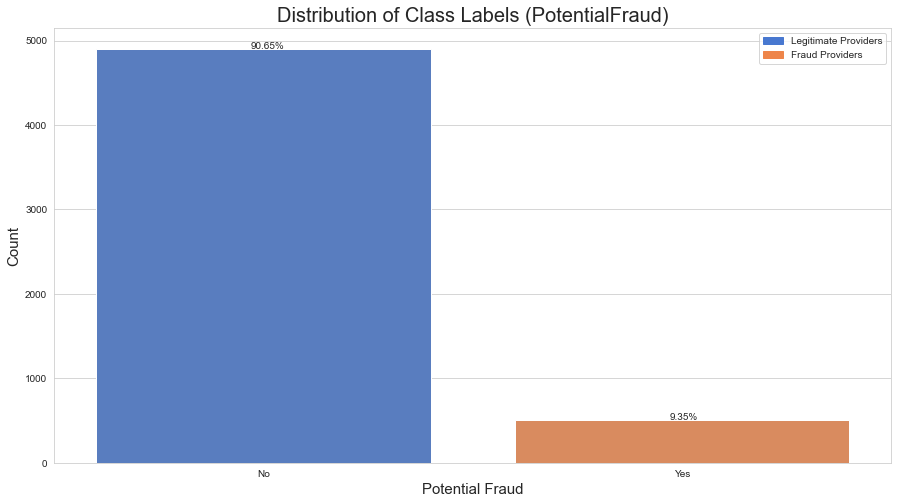

Wall time: 459 ms


In [ ]:
%%time
# Call the custom function 'countPlot' to plot the Count Plot for the 'PotentialFraud' Feature
countPlot(figsize=(15,8), title='Distribution of Class Labels (PotentialFraud)', xlabel='Potential Fraud', ylabel='Count',
          data=dataProvider, feature='PotentialFraud', legends=['Legitimate Providers', 'Fraud Providers'], 
          showLegend=True)

#### Observation from the EDA of the Provider Dataset

* There are a total of 5410 datapoints, each signifying a Provider ID and a Class Label 'PotentialFraud' indicating whether the given Provider is fraudulent or not.
* Based on the dataframe.info() method, we can see that there are **no missing values** in the Provider dataset.
* This is a case of **binary classification** task because the Class Label 'PotentialFraud' has only two unique values:<br>
&emsp; i. No: Indicates that the Provider is non-fraudulent.<br>
&emsp; ii. Yes: Indicates that the Provider is fraudulent.<br>
* The dataset is **highly imbalanced** with 90.6% non-fraud Providers and 9.4% fraud Providers class labels.

----

## <font color="blue">3.2. EDA of Beneficiary Dataset</font>

In [ ]:
dataBeneficiary.head()

,BeneID,DOB,DOD,Gender,Race,RenalDiseaseIndicator,State,County,NoOfMonths_PartACov,NoOfMonths_PartBCov,ChronicCond_Alzheimer,ChronicCond_Heartfailure,ChronicCond_KidneyDisease,ChronicCond_Cancer,ChronicCond_ObstrPulmonary,ChronicCond_Depression,ChronicCond_Diabetes,ChronicCond_IschemicHeart,ChronicCond_Osteoporasis,ChronicCond_rheumatoidarthritis,ChronicCond_stroke,IPAnnualReimbursementAmt,IPAnnualDeductibleAmt,OPAnnualReimbursementAmt,OPAnnualDeductibleAmt
0,BENE11001,1943-01-01,NaN,1,1,0,39,230,12,12,1,2,1,2,2,1,1,1,2,1,1,36000,3204,60,70
1,BENE11002,1936-09-01,NaN,2,1,0,39,280,12,12,2,2,2,2,2,2,2,2,2,2,2,0,0,30,50
2,BENE11003,1936-08-01,NaN,1,1,0,52,590,12,12,1,2,2,2,2,2,2,1,2,2,2,0,0,90,40
3,BENE11004,1922-07-01,NaN,1,1,0,39,270,12,12,1,1,2,2,2,2,1,1,1,1,2,0,0,1810,760
4,BENE11005,1935-09-01,NaN,1,1,0,24,680,12,12,2,2,2,2,1,2,1,2,2,2,2,0,0,1790,1200


In [ ]:
print('Shape of the Beneficiary Dataset: ', dataBeneficiary.shape)
print('Number of features in the Beneficiary Dataset: ', dataBeneficiary.shape[1])

Shape of the Beneficiary Dataset:  (138556, 25)
Number of features in the Beneficiary Dataset:  25


In [ ]:
dataBeneficiary.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 138556 entries, 0 to 138555
Data columns (total 25 columns):
 #   Column                           Non-Null Count   Dtype 
---  ------                           --------------   ----- 
 0   BeneID                           138556 non-null  object
 1   DOB                              138556 non-null  object
 2   DOD                              1421 non-null    object
 3   Gender                           138556 non-null  int64 
 4   Race                             138556 non-null  int64 
 5   RenalDiseaseIndicator            138556 non-null  object
 6   State                            138556 non-null  int64 
 7   County                           138556 non-null  int64 
 8   NoOfMonths_PartACov              138556 non-null  int64 
 9   NoOfMonths_PartBCov              138556 non-null  int64 
 10  ChronicCond_Alzheimer            138556 non-null  int64 
 11  ChronicCond_Heartfailure         138556 non-null  int64 
 12  ChronicCond_Kidn

#### Observation

* None of the features have missing values except the feature 'DOD'.
* DOD feature have lot of missing values.

### <font color="blue">3.2.1. EDA of Beneficiary Dataset - Gender Feature</font>

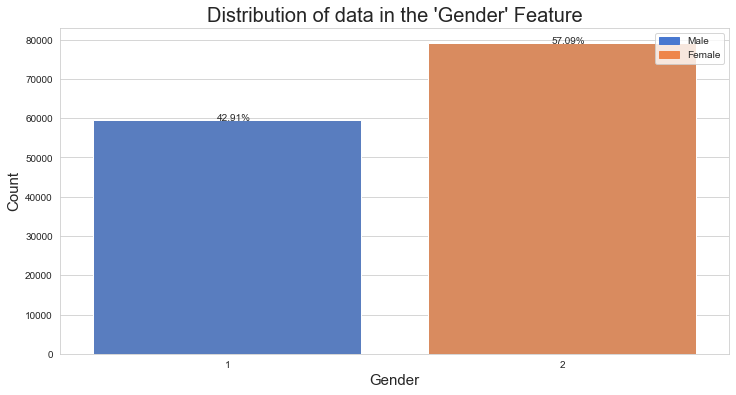

Wall time: 329 ms


In [ ]:
%%time
# Call the custom function 'countPlot' to plot the Count Plot for the 'Gender' Feature
countPlot(figsize=(12,6), title='Distribution of data in the \'Gender\' Feature', xlabel='Gender', ylabel='Count',
          data=dataBeneficiary, feature='Gender', legends=['Male', 'Female'],  # Assuming 1 is for Male and 2 is for Female
          showLegend=True)

#### Observation from the EDA of the 'Gender' Feature

* Gender feature is almost balanced.
* 42.9% of the beneficiaries (patients) are males and rest 57.1% are females.

### <font color="blue">3.2.2. EDA of Beneficiary Dataset - Race Feature</font>

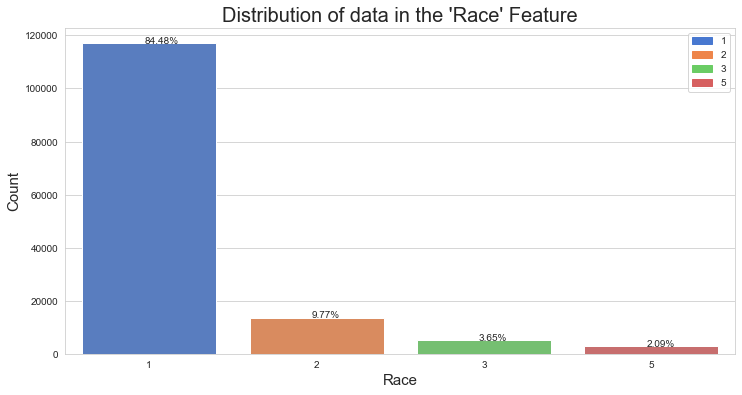

Wall time: 390 ms


In [ ]:
%%time
# Call the custom function 'countPlot' to plot the Count Plot for the 'Race' Feature
countPlot(figsize=(12,6), title='Distribution of data in the \'Race\' Feature', xlabel='Race', ylabel='Count',
          data=dataBeneficiary, feature='Race', legends=dataBeneficiary['Race'].unique(), showLegend=True)

#### Observation from the EDA of the 'Race' Feature

* There are four different races: '1', '2', '3' and '5'.
* Most of the beneficiaries (84.5%) belong to race '1', followed by race '2', '3' and '5'.
* Very few beneficiaries (2.1%) belong to race '5'.

### <font color="blue">3.2.3. EDA of Beneficiary Dataset - RenalDiseaseIndicator Feature</font>

* Renal Disease Indicator is a flag to indicate whether beneficiar has any problem related to kidney failure or not.

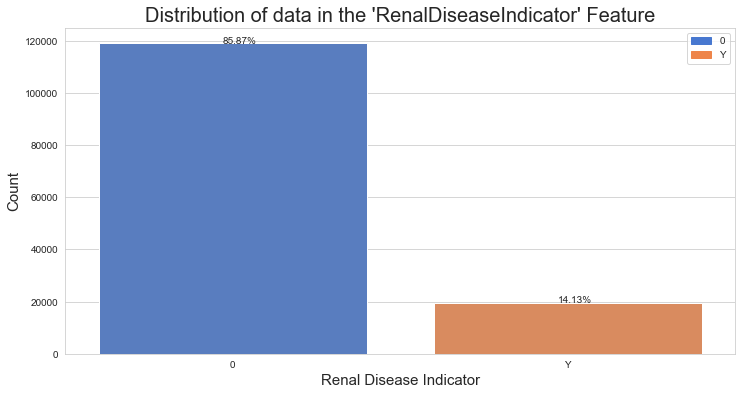

Wall time: 484 ms


In [ ]:
%%time
# Call the custom function 'countPlot' to plot the Count Plot for the 'RenalDiseaseIndicator' Feature
countPlot(figsize=(12,6), title='Distribution of data in the \'RenalDiseaseIndicator\' Feature', 
          xlabel='Renal Disease Indicator', ylabel='Count', data=dataBeneficiary, feature='RenalDiseaseIndicator',
          legends=dataBeneficiary['RenalDiseaseIndicator'].unique(), showLegend=True)

#### Observation from the EDA of the 'RenalDiseaseIndicator' Feature

* As this feature is a flag to indicate any kind of renal disease, there are two possible values: 0/No and 'Y'/Yes.
* Most of the beneficiaries (85.87%) do not have any renal disease.

### <font color="blue">3.2.4. EDA of Beneficiary Dataset - State Feature</font>

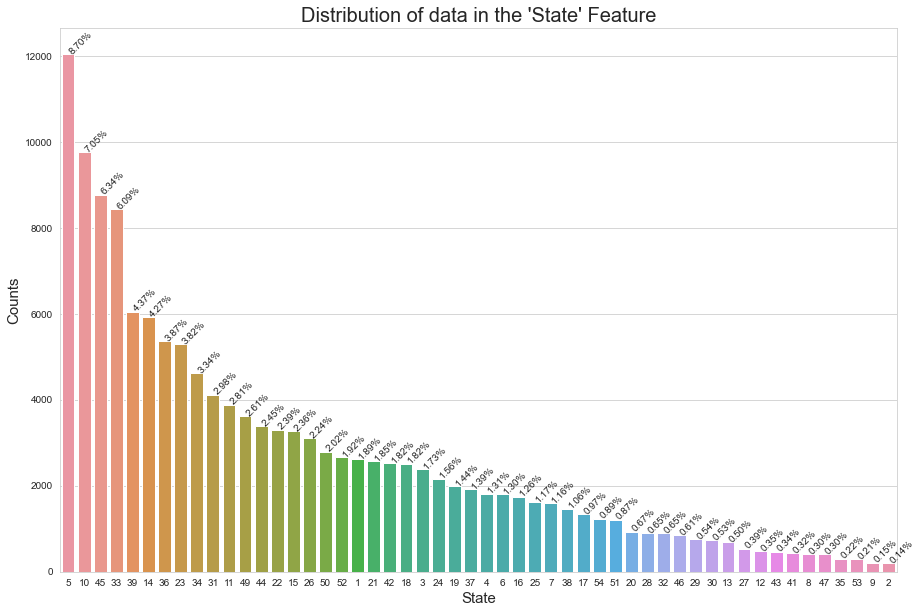

Wall time: 3.3 s


In [ ]:
%%time
# Call the custom function 'countPlot' to plot the Count Plot for the 'State' Feature
countPlot(figsize=(15,10), title='Distribution of data in the \'State\' Feature', xlabel='State', ylabel='Counts',
          data=dataBeneficiary, feature='State', annotRotation=45, firstK=len(dataBeneficiary['State'].unique()),
          annotateRotate=45)

In [ ]:
print('No. of unique states: ', len(dataBeneficiary['State'].unique()))

No. of unique states:  52


#### Observation from the EDA of the 'State' Feature

* There are a total of 52 states.
* State with maximum beneficiaries (8.70%) is state encoded as '5'.
* State with minimum beneficiaries (0.14%) is state encoded as '2'.

### <font color="blue">3.2.5. EDA of Beneficiary Dataset - Country Feature</font>

In [ ]:
print('No. of unique countries: ', len(dataBeneficiary['County'].unique()))

No. of unique countries:  314


* Let's plot the top 50 Countries, otherwise the bars in the plot will be too much overlapping.

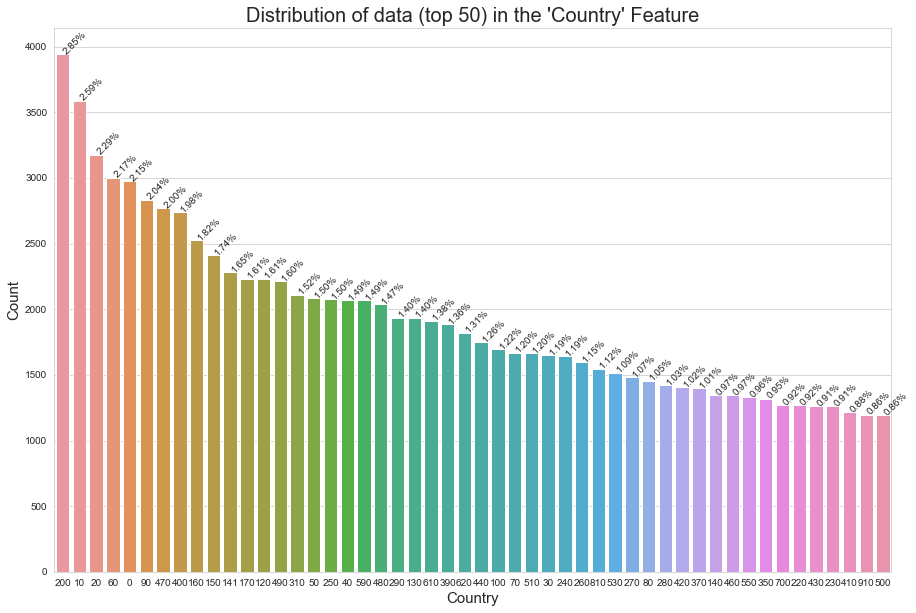

Wall time: 2.37 s


In [ ]:
%%time
# Call the custom function 'countPlot' to plot the Count Plot for the top 50 countries
countPlot(figsize=(15,10), title='Distribution of data (top 50) in the \'Country\' Feature',
          xlabel='Country', ylabel='Count', data=dataBeneficiary, feature='County', firstK=50, annotateRotate=45)

#### Observation from the EDA of the 'Country' Feature

* There are a total of 314 countries.
* Countries having maximum beneficiaries are in the order: 200, 10, 20 and so on.
* Countries encoded as '200' has 2.85% of the benficiaries.

### <font color="blue">3.2.6. EDA of Beneficiary Dataset - NoOfMonths_PartACov and NoOfMonths_PartBCov Feature</font>

#### <font color="blue">3.2.6.1. NoOfMonths_PartACov Feature</font>

In [ ]:
print('No. of unique values of the feature \'NoOfMonths_PartACov\': ', 
      len(dataBeneficiary['NoOfMonths_PartACov'].unique()))

No. of unique values of the feature 'NoOfMonths_PartACov':  13


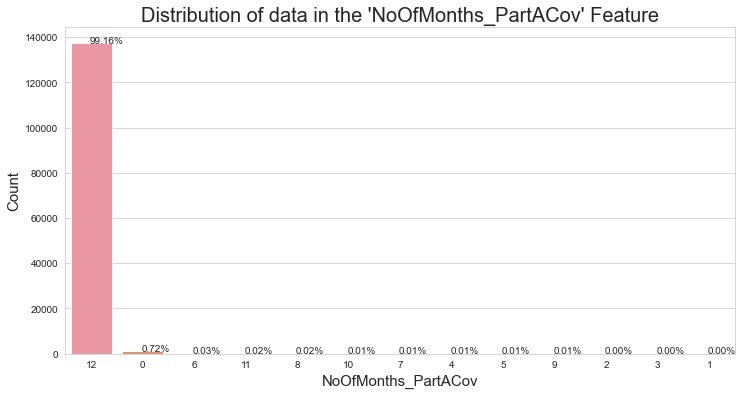

Wall time: 705 ms


In [ ]:
%%time
# Call the custom function 'countPlot' to plot the Count Plot for the 'NoOfMonths_PartACov' feature
countPlot(figsize=(12,6), title='Distribution of data in the \'NoOfMonths_PartACov\' Feature',
          xlabel='NoOfMonths_PartACov', ylabel='Count', data=dataBeneficiary, 
          firstK=len(dataBeneficiary['NoOfMonths_PartACov'].unique()), feature='NoOfMonths_PartACov')

#### Observation from the EDA of the 'NoOfMonths_PartACov' Feature

* 99.16% of the data in the 'NoOfMonths_PartACov' feature has a value of '12' and 0.72% of the data has a value of '0'.
* All other values are negligible.
* As almost all values of this feature is having value of 12, this feature won't make any impact in doing the classification. Hence, we can drop this feature.

#### <font color="blue">3.2.6.2. NoOfMonths_PartBCov Feature</font>

In [ ]:
print('No. of unique values of the feature \'NoOfMonths_PartBCov\': ', 
      len(dataBeneficiary['NoOfMonths_PartBCov'].unique()))

No. of unique values of the feature 'NoOfMonths_PartBCov':  13


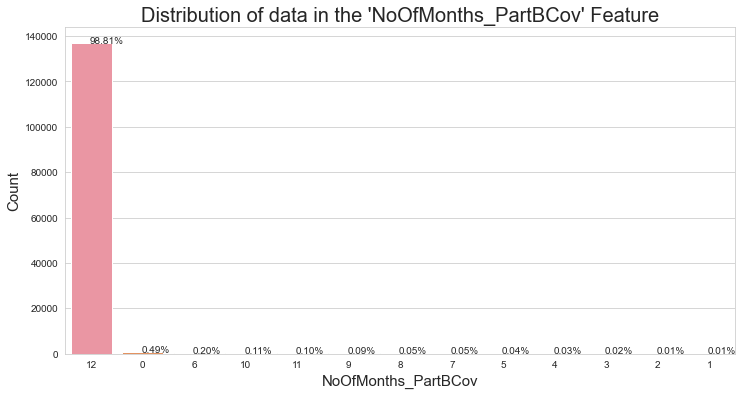

Wall time: 605 ms


In [ ]:
%%time
# Call the custom function 'countPlot' to plot the Count Plot for the 'NoOfMonths_PartBCov' feature
countPlot(figsize=(12,6), title='Distribution of data in the \'NoOfMonths_PartBCov\' Feature',
          xlabel='NoOfMonths_PartBCov', ylabel='Count', data=dataBeneficiary, 
          firstK=len(dataBeneficiary['NoOfMonths_PartBCov'].unique()), feature='NoOfMonths_PartBCov')

#### Observation from the EDA of the 'NoOfMonths_PartBCov' Feature

* 98.81% of the data in the 'NoOfMonths_PartBCov' feature has a value of '12'.
* All other values are negligible.
* As almost all values of this feature is having value of 12, this feature won't make any impact in doing the classification. Hence, we can drop this feature.

### <font color="blue">3.2.7. EDA of Beneficiary Dataset - Chronic Condition Features</font>

* EDA of all the Chronic Condition Features:<br>
&emsp; 1. ChronicCond_Alzheimer.<br>
&emsp; 2. ChronicCond_Heartfailure.<br>
&emsp; 3. ChronicCond_KidneyDisease.<br>
&emsp; 4. ChronicCond_Cancer.<br>
&emsp; 5. ChronicCond_ObstrPulmonary.<br>
&emsp; 6. ChronicCond_Depression.<br>
&emsp; 7. ChronicCond_Diabetes.<br>
&emsp; 8. ChronicCond_IschemicHeart.<br>
&emsp; 9. ChronicCond_Osteoporasis.<br>
&emsp; 10. ChronicCond_rheumatoidarthritis.<br>
&emsp; 11. ChronicCond_stroke.<br>
* All the Chronic Condition features have binary values, either 1 or 2.
* Assuming '2' for 'No' and '1' for 'Yes'.
* Will replace '2' with '0' to indicate '0' as 'No' and '1' as 'Yes', when doing the featurization.

  0%|          | 0/11 [00:00<?, ?it/s]

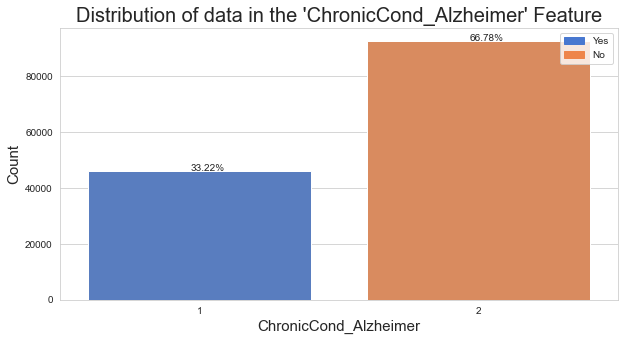

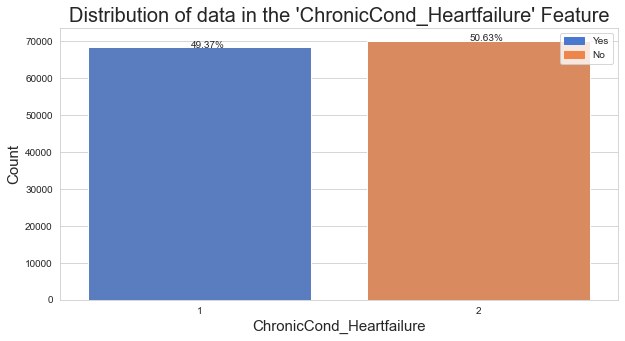

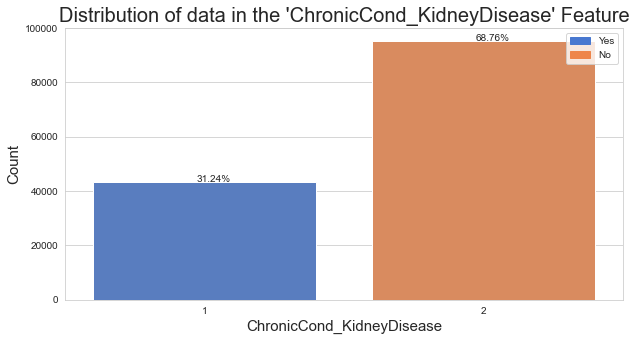

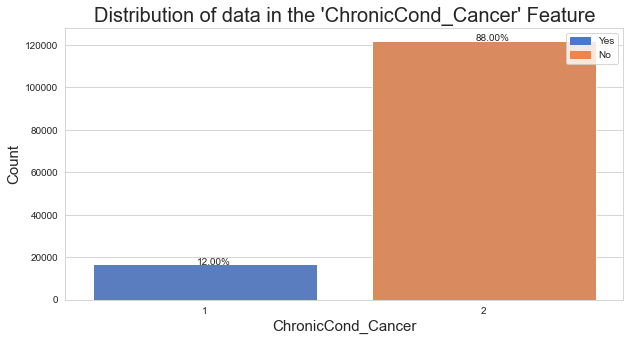

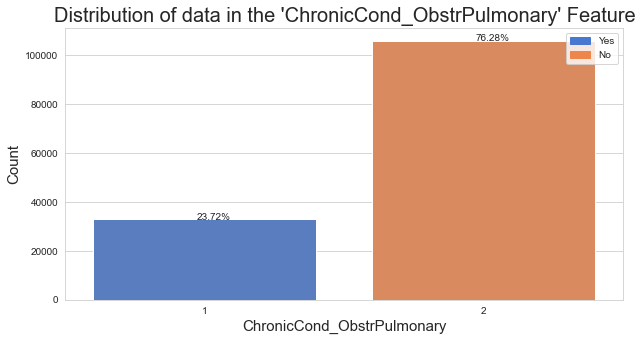

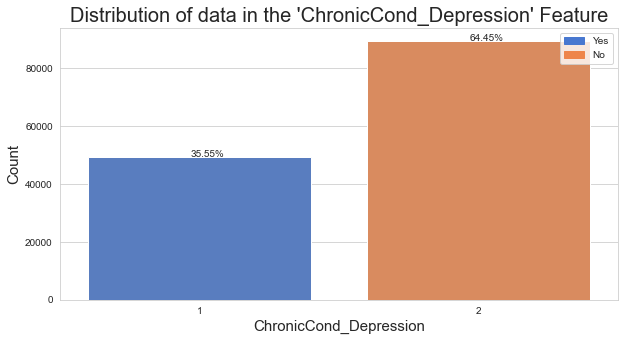

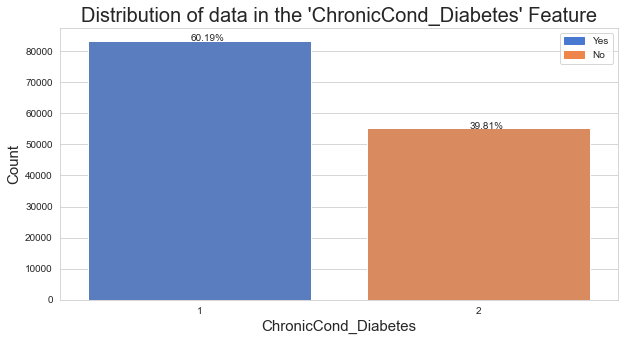

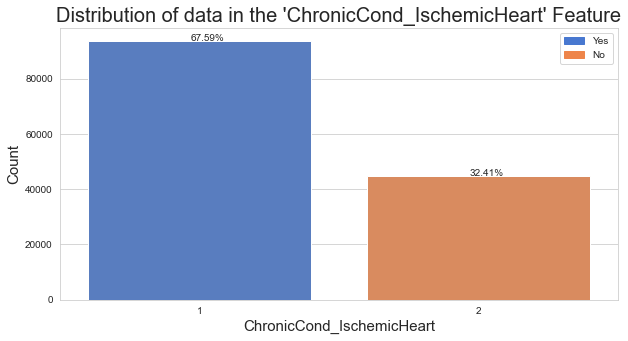

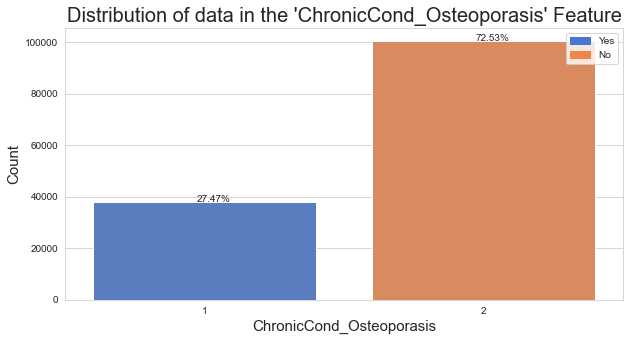

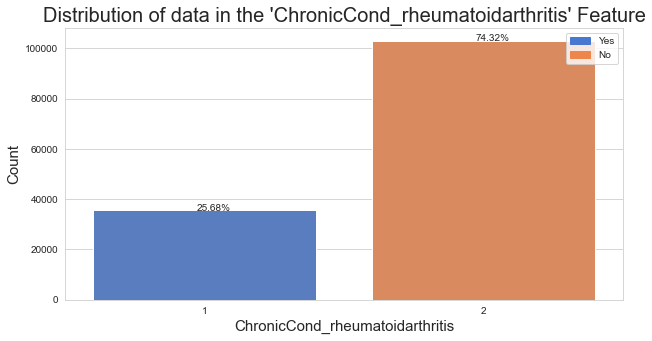

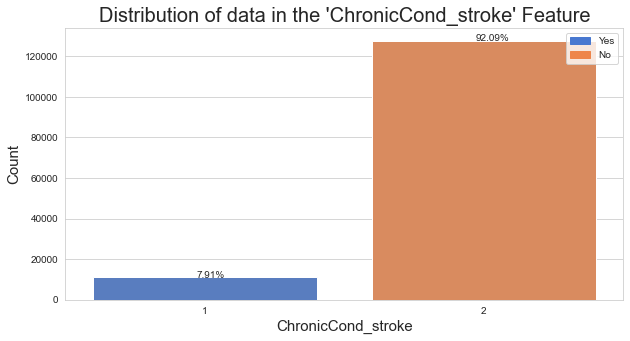

Wall time: 3.82 s


In [ ]:
%%time
# Display Count Plot for all the Chronic Condition features
for chronicFeature in tqdm([feature for feature in dataBeneficiary.columns if 'Chronic' in feature]):
    
    # Call the custom function 'countPlot' to plot the Count Plot for the Chronic Condition features
    countPlot(figsize=(10,5), title='Distribution of data in the \'' + chronicFeature + '\' Feature',
          xlabel=chronicFeature, ylabel='Count', data=dataBeneficiary, feature=chronicFeature,
          legends=['Yes', 'No'], showLegend=True) # Assuming '2' as 'No' and '1' as 'Yes'
    
    print('==========================================================================================================')

#### Observation from the EDA of the Chronic Condition Features

* There are two values in each of the Chronic Condition features: '1' and '2'.
* The value of '2' will be replaced with '0' to indicate '0' as 'No' and '1' as 'Yes' later during the featurization.
* The data is reasonably balanced for all features except for 'ChronicCond_Cancer' and 'ChronicCond_stroke' where the data is imbalanced.

### <font color="blue">3.2.8. EDA of Beneficiary Dataset - Annual Reimbursement and Deductible Amount Features for both Inpatient and Outpatient</font>

* The below four features are numerical features and we would plot the Histogram/PDF and Box Plot for these:<br>
&emsp; 1. IPAnnualReimbursementAmt.<br>
&emsp; 2. IPAnnualDeductibleAmt.<br>
&emsp; 3. OPAnnualReimbursementAmt.<br>
&emsp; 4. OPAnnualDeductibleAmt.<br>

In [ ]:
dataBeneficiary['OPAnnualReimbursementAmt'].isnull().any()

False

  0%|          | 0/4 [00:00<?, ?it/s]

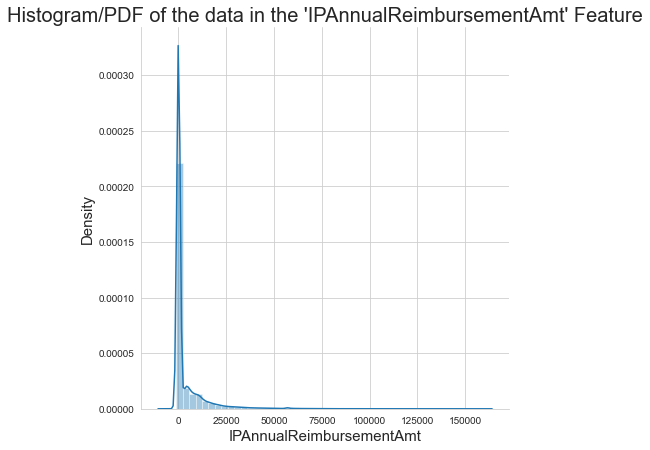

----------------------------------------------------------------------------------------------------------


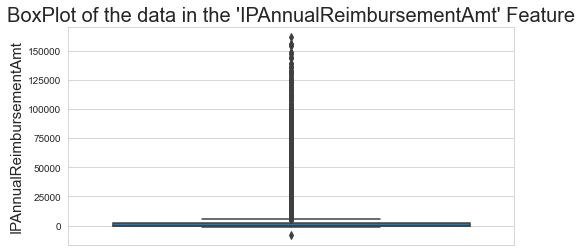

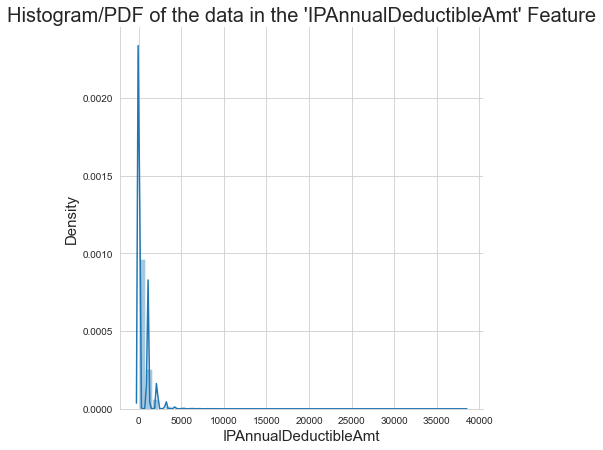

----------------------------------------------------------------------------------------------------------


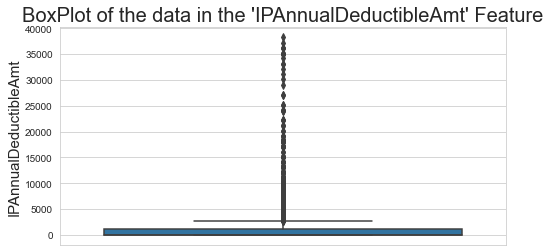

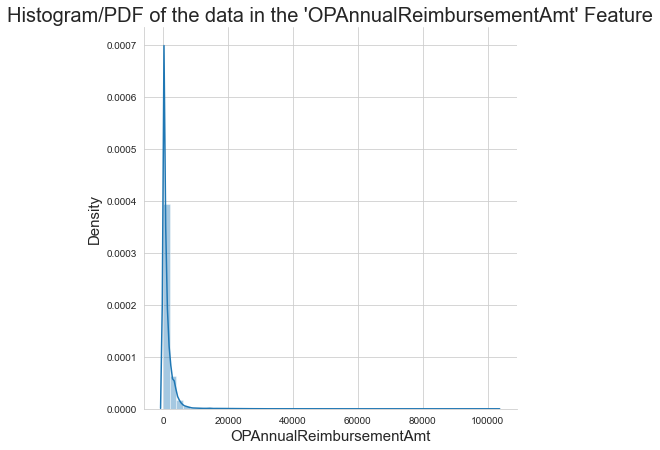

----------------------------------------------------------------------------------------------------------


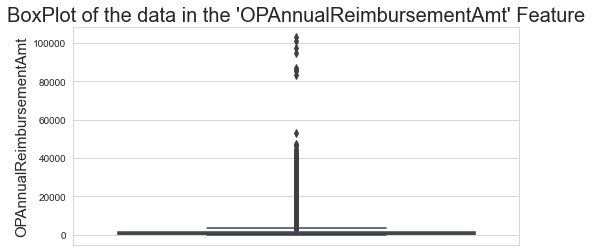

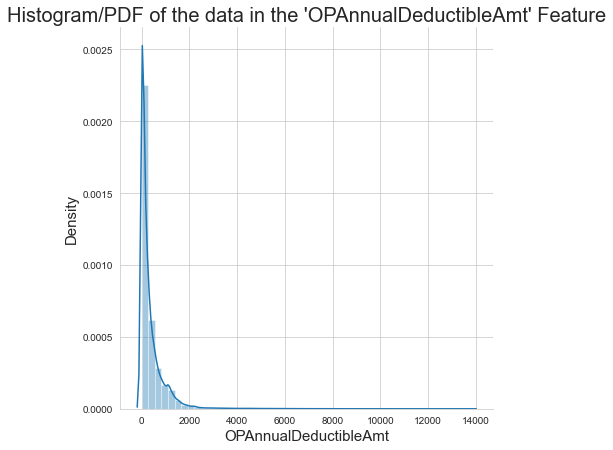

----------------------------------------------------------------------------------------------------------


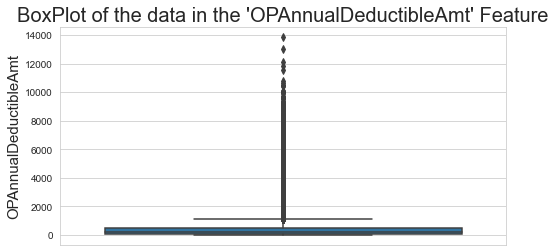

Wall time: 20.7 s


In [ ]:
%%time
# Display Count Plot and Box Plot for all the Annual Reimbursement and Deductible Amount features
for amtFeature in tqdm([feature for feature in dataBeneficiary.columns if 'Annual' in feature]):
    plotNumFeat(type='Density', data=dataBeneficiary, feature=amtFeature, figureHeight=6,
                title='Histogram/PDF of the data in the \'' + amtFeature + '\' Feature',
                xlabel=amtFeature, ylabel='Density')
    
    print('----------------------------------------------------------------------------------------------------------')
    
    plotNumFeat(type='Box', figsize=(8,4), data=dataBeneficiary, feature=amtFeature,
                title='BoxPlot of the data in the \'' + amtFeature + '\' Feature',
                xlabel='', ylabel=amtFeature)
    
    print('==========================================================================================================')

#### Observation from the EDA of the Annual Reimbursement and Deductible Amount Features for both Inpatient and Outpatient¶

* For IPAnnualReimbursementAmt Feature, most of the amount lies between 0 and 5000.
* For IPAnnualDeductibleAmt Feature, most of the amount lies between 0 and 2000.
* For OPAnnualReimbursementAmt Feature, most of the amount lies between 0 and 5000.
* For OPAnnualDeductibleAmt Feature, most of the amount lies between 0 and 2000.
* Rest all the amounts greater than the above ranges are outliers. In this case study, those high amount values can be the potential fraud cases. Hence, we won't remove those outliers.

### <font color="blue">3.2.9. EDA of Beneficiary Dataset - Date of Birth Feature</font>

* Let's plot a Count Plot based on the beneficiary's year of birth.

In [ ]:
# Generate new feature 'YOB' (Year of Birth)
dataBeneficiary['YOB'] = pd.to_datetime(dataBeneficiary['DOB']).dt.year

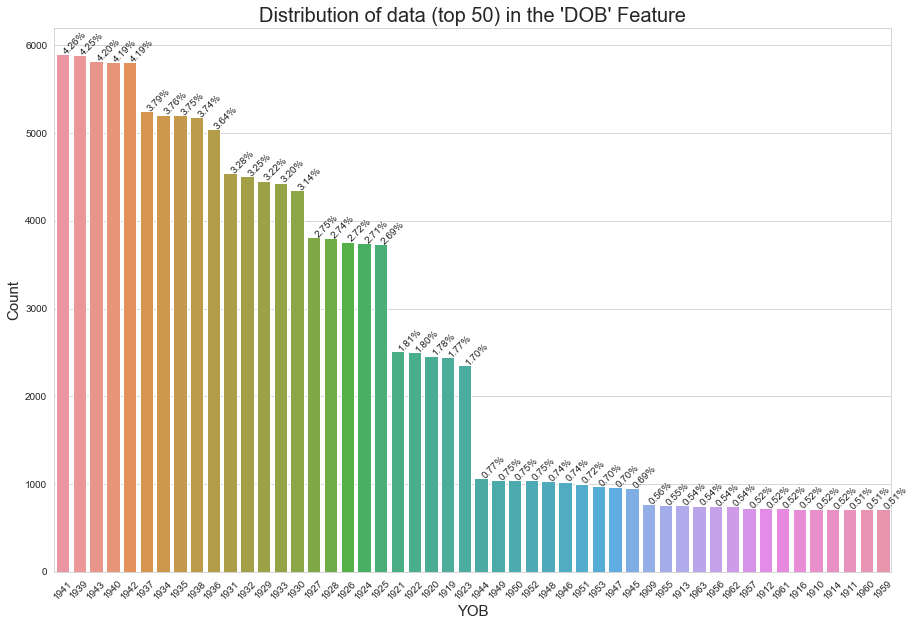

Wall time: 2.59 s


In [ ]:
%%time
# Call the custom function 'countPlot' to plot the Count Plot for the top 50 'YOB' feature
countPlot(figsize=(15,10), title='Distribution of data (top 50) in the \'DOB\' Feature',
          xlabel='YOB', ylabel='Count', data=dataBeneficiary,
          firstK=50, feature='YOB', annotateRotate=45, xtickRotate=45)

#### Observation from Year of Birth

* Most of the patients were born in the year 1941, followed by the years: 1939, 1943, 1940 and so on.

### <font color="blue">3.2.9. EDA of Beneficiary Dataset - Date of Death Feature</font>

* Let's plot a Count Plot based on the beneficiary's year of death.

In [ ]:
# Generate new feature 'YOD' (Year of Death)
dataBeneficiary['YOD'] = pd.to_datetime(dataBeneficiary['DOD']).dt.year

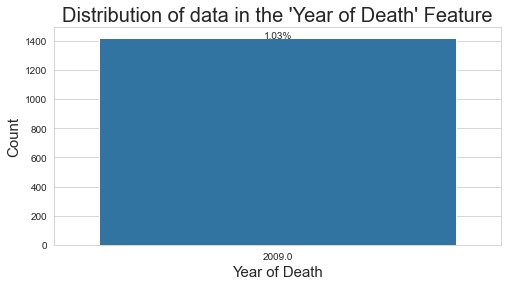

Wall time: 227 ms


In [ ]:
%%time
# Call the custom function 'countPlot' to plot the Count Plot for the Year of Death feature
countPlot(figsize=(8,4), title='Distribution of data in the \'Year of Death\' Feature',
          xlabel='Year of Death', ylabel='Count', data=dataBeneficiary, feature='YOD')

* As all the patients who are dead, died in the same year '2009', let's draw a plot for the months in which they died. 

In [ ]:
# Generate new feature 'YOB' (Year of Birth)
dataBeneficiary['MOD'] = pd.to_datetime(dataBeneficiary['DOD']).dt.month

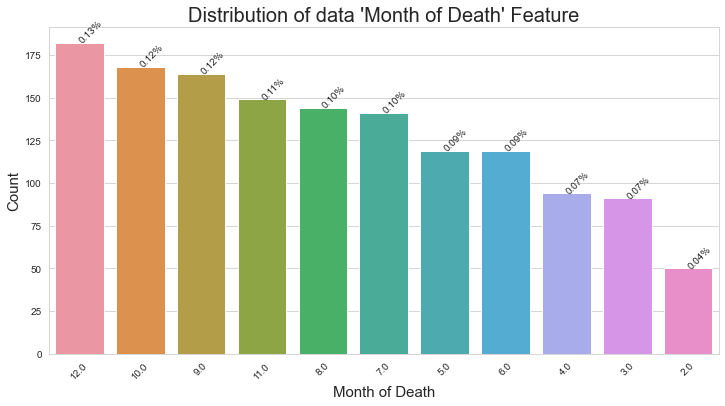

Wall time: 515 ms


In [ ]:
%%time
# Call the custom function 'countPlot' to plot the Count Plot for the Month of Death feature
countPlot(figsize=(12,6), title='Distribution of data \'Month of Death\' Feature', firstK=12,
          xlabel='Month of Death', ylabel='Count', data=dataBeneficiary, feature='MOD', annotateRotate=45, xtickRotate=45)

#### Observation from the EDA of features related to the DOD (Date of Death)

* All the dead patients died in the year '2009'.
* Most of the dead patients died in the December month.

----

## <font color="blue">3.3. EDA of Inpatient and Outpatient Dataset</font>

* Inpatient Dataset has a total of 30 features and Outpatient Dataset has a total of 27 features.
* All the 27 features of Outpatient are also present in the Inpatient Dataset.
* Inpatient Dataset has 3 extra features viz., 'AdmissionDt', 'DischargeDt' and 'DiagnosisGroupCode'.
* Hence, we will merge the data from the Inpatient and Outpatient Dataset along the common columns and do the EDA on the merged data.

### <font color="blue">3.3.1. Merge the Inpatient and Outpatient Dataset</font>

* Inpatient and Outpatient contains almost all similar features and hence, can be concatenated. This would give a single dataset containing the details of both inpatient and outpatient details related to the claims.

In [ ]:
dataClaim = pd.concat([dataInpatient, dataOutpatient]) # Concat the Inpatient and Outpatient Datasets.

In [ ]:
dataClaim.head() # Display top 5 records from the merged dataset

,BeneID,ClaimID,ClaimStartDt,ClaimEndDt,Provider,InscClaimAmtReimbursed,AttendingPhysician,OperatingPhysician,OtherPhysician,AdmissionDt,ClmAdmitDiagnosisCode,DeductibleAmtPaid,DischargeDt,DiagnosisGroupCode,ClmDiagnosisCode_1,ClmDiagnosisCode_2,ClmDiagnosisCode_3,ClmDiagnosisCode_4,ClmDiagnosisCode_5,ClmDiagnosisCode_6,ClmDiagnosisCode_7,ClmDiagnosisCode_8,ClmDiagnosisCode_9,ClmDiagnosisCode_10,ClmProcedureCode_1,ClmProcedureCode_2,ClmProcedureCode_3,ClmProcedureCode_4,ClmProcedureCode_5,ClmProcedureCode_6
0,BENE11001,CLM46614,2009-04-12,2009-04-18,PRV55912,26000,PHY390922,NaN,NaN,2009-04-12,7866,1068.0,2009-04-18,201,1970,4019,5853,7843,2768,71590,2724,19889,5849,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,BENE11001,CLM66048,2009-08-31,2009-09-02,PRV55907,5000,PHY318495,PHY318495,NaN,2009-08-31,6186,1068.0,2009-09-02,750,6186,2948,56400,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7092.0,NaN,NaN,NaN,NaN,NaN
2,BENE11001,CLM68358,2009-09-17,2009-09-20,PRV56046,5000,PHY372395,NaN,PHY324689,2009-09-17,29590,1068.0,2009-09-20,883,29623,30390,71690,34590,V1581,32723,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,BENE11011,CLM38412,2009-02-14,2009-02-22,PRV52405,5000,PHY369659,PHY392961,PHY349768,2009-02-14,431,1068.0,2009-02-22,067,43491,2762,7843,32723,V1041,4254,25062,40390,4019,NaN,331.0,NaN,NaN,NaN,NaN,NaN
4,BENE11014,CLM63689,2009-08-13,2009-08-30,PRV56614,10000,PHY379376,PHY398258,NaN,2009-08-13,78321,1068.0,2009-08-30,975,042,3051,34400,5856,42732,486,5119,29620,20300,NaN,3893.0,NaN,NaN,NaN,NaN,NaN


In [ ]:
print('Number of unique Claim IDs in the dataset: ', len(dataClaim['ClaimID'].unique()))
print('Total number of datapoints in the dataset: ', dataClaim.shape[0])

Number of unique Claim IDs in the dataset:  558211
Total number of datapoints in the dataset:  558211


* As we can see that the number of unique Claim IDs in the merged dataset is equal to the total number of datapoints in the dataset, each record (datapoint) can be thought of as an information related to an insurance claim submitted.
* Hence, we can call the new merged dataset as **Claim Dataset**.

In [ ]:
print('Shape of the Claim Dataset: ', dataClaim.shape)
print('Number of features in the Claim Dataset: ', dataClaim.shape[1])

Shape of the Claim Dataset:  (558211, 30)
Number of features in the Claim Dataset:  30


In [ ]:
dataClaim.info() # Concise summary of the Claim Dataset

<class 'pandas.core.frame.DataFrame'>
Int64Index: 558211 entries, 0 to 517736
Data columns (total 30 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   BeneID                  558211 non-null  object 
 1   ClaimID                 558211 non-null  object 
 2   ClaimStartDt            558211 non-null  object 
 3   ClaimEndDt              558211 non-null  object 
 4   Provider                558211 non-null  object 
 5   InscClaimAmtReimbursed  558211 non-null  int64  
 6   AttendingPhysician      556703 non-null  object 
 7   OperatingPhysician      114447 non-null  object 
 8   OtherPhysician          199736 non-null  object 
 9   AdmissionDt             40474 non-null   object 
 10  ClmAdmitDiagnosisCode   145899 non-null  object 
 11  DeductibleAmtPaid       557312 non-null  float64
 12  DischargeDt             40474 non-null   object 
 13  DiagnosisGroupCode      40474 non-null   object 
 14  ClmDiagnosisCode_1  

* As we have the 'Provider' feature present in the Claim Dataset, let's merge it with the 'Provider' dataset to get the Class Label as well.
* This will help us get meaningful insights of the relationship between the features and the class labels.

In [ ]:
dataClaim = pd.merge(left=dataClaim, right=dataProvider, how='inner', on='Provider')

* The features: 'BeneID' and 'ClaimID' are the unique identifiers for the Beneficiaries and the Claims and won't contribute anything to the classification. Hence, we can ignore them while doing the EDA.

### <font color="blue">3.3.1. EDA of Claim (Inpatient and Outpatient) Dataset - Date Features</font>

* There are four date features in the Claim dataset:<br>
&emsp; 1. ClaimStartDt: Date on which the insurance claim was submitted.<br>
&emsp; 2. ClaimEndDt: Date on which the insurance claim was settled and closed.<br>
&emsp; 3. AdmissionDt (Inpatient data): Date on which the patient was admitted to the hospital.<br>
&emsp; 4. DischargeDt (Inpatient data): Date on which the patient was discharged from the hospital.<br>
* We will derive the below new features from these date features to do EDA:<br>
&emsp; 1. Claim Settlement Delay: Difference between the Claim End Date and Claim Start Date.<br>
&emsp; 2. Treatment Duration: Difference between Discharge Date and Admission Date.<br>


In [ ]:
# Date related columns
colDate = [col for col in dataClaim.columns if 'Dt' in col]

print('Date related columns: ', colDate)

Date related columns:  ['ClaimStartDt', 'ClaimEndDt', 'AdmissionDt', 'DischargeDt']


In [ ]:
# Convert these columns to DateTime Format
dataClaim[colDate] = dataClaim[colDate].apply(pd.to_datetime)

In [ ]:
# Generate new Feature 'ClaimSettlementDelay' (ClaimEndDt - ClaimStartDt)
dataClaim['ClaimSettlementDelay'] = (dataClaim['ClaimEndDt'] - dataClaim['ClaimStartDt']).dt.days

# Generate new Feature 'TreatmentDuration' (DischargeDt - AdmissionDt)
dataClaim['TreatmentDuration'] = (dataClaim['DischargeDt'] - dataClaim['AdmissionDt']).dt.days

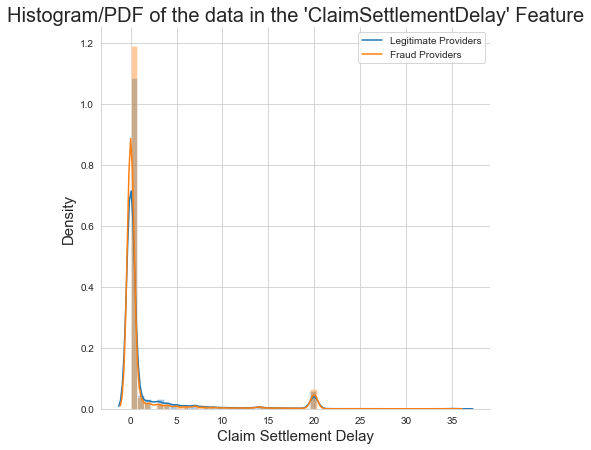

----------------------------------------------------------------------------------------------------------


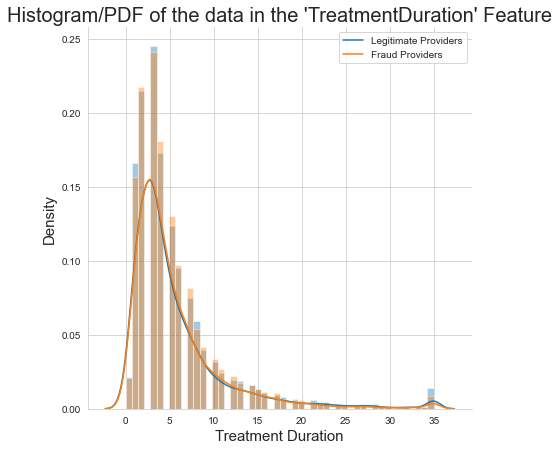

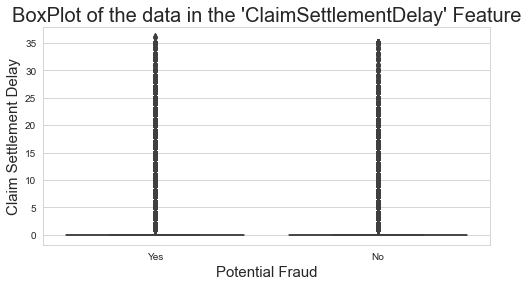

----------------------------------------------------------------------------------------------------------


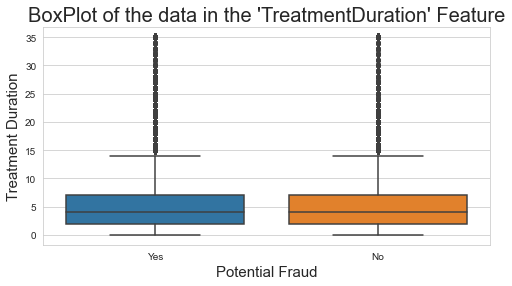

Wall time: 48.6 s


In [ ]:
%%time
# Call the custom function 'plotNumFeat' to plot the Histogram/PDF of the 'ClaimSettlementDelay' feature data.
plotNumFeat(type='Density', data=dataClaim, feature='ClaimSettlementDelay', figureHeight=6,
            title='Histogram/PDF of the data in the \'' + 'ClaimSettlementDelay' + '\' Feature', hue='PotentialFraud',
            xlabel='Claim Settlement Delay', ylabel='Density')

print('----------------------------------------------------------------------------------------------------------')

# Call the custom function 'plotNumFeat' to plot the Histogram/PDF of the 'TreatmentDuration' feature data.
plotNumFeat(type='Density', data=dataClaim, feature='TreatmentDuration', figureHeight=6,
            title='Histogram/PDF of the data in the \'' + 'TreatmentDuration' + '\' Feature', hue='PotentialFraud',
            xlabel='Treatment Duration', ylabel='Density')

print('==========================================================================================================')

# Call the custom function 'plotNumFeat' to plot the BoxPlot of the 'ClaimSettlementDelay' feature data.
plotNumFeat(type='Box', figsize=(8,4), data=dataClaim, feature='ClaimSettlementDelay',
            title='BoxPlot of the data in the \'' + 'ClaimSettlementDelay' + '\' Feature', hue='PotentialFraud',
            xlabel='Potential Fraud', ylabel='Claim Settlement Delay')

print('----------------------------------------------------------------------------------------------------------')

# Call the custom function 'plotNumFeat' to plot the BoxPlot of the 'TreatmentDuration' feature data
plotNumFeat(type='Box', figsize=(8,4), data=dataClaim, feature='TreatmentDuration',
            title='BoxPlot of the data in the \'' + 'TreatmentDuration' + '\' Feature', hue='PotentialFraud',
            xlabel='Potential Fraud', ylabel='Treatment Duration')

print('==========================================================================================================')

#### Observation from the EDA of the 'ClaimSettlementDelay' and 'TreatmentDuration' Features

* The distribution of data in both the 'ClaimSettlementDelay' and 'TreatmentDuration' features follow the similar pattern. The 'TreatmentDuration' is present only for Inpatient data and not for Outpatient data.
* Hence, we can keep 'ClaimSettlementDelay' and **discard the 'TreatmentDuration' feature**.
* Also, the data distribution for both classes (fraud and non-fraud) for each feature follow same trend.
* There are outliers in the feature for both fraudulent and non-fraudulent cases, which should not be removed because those could be critical factors to identify a claim records as fraudulent or not.

### <font color="blue">3.3.2. EDA of Claim (Inpatient and Outpatient) Dataset - Amount Features</font>

* There are two numeric features related to amount:<br>
&emsp; 1. InscClaimAmtReimbursed: Amount reimbursed by the Payer (Insurance Agency) for the healthcare services provided to the beneficiary.<br>
&emsp; 2. DeductibleAmtPaid: Amount the beneficiary has to pay as part of the claim, and the rest of the amount is paid by
the insurance company. It is equal to the total claim amount minus the reimbursed amount.

#### <font color="blue">3.3.2.1. InscClaimAmtReimbursed Feature</font>

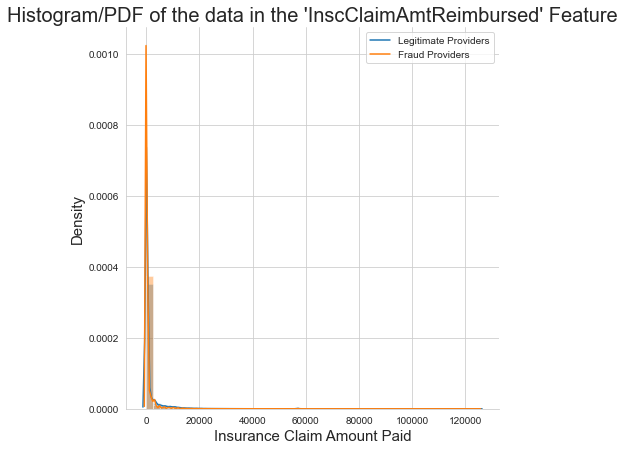

----------------------------------------------------------------------------------------------------------


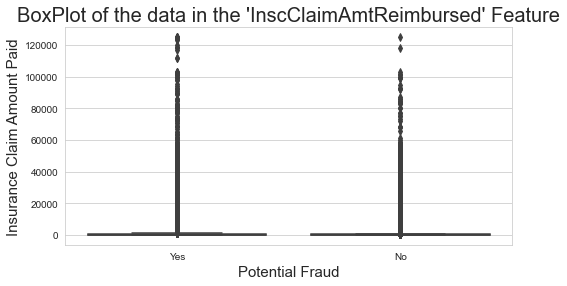

Wall time: 32.7 s


In [ ]:
%%time
# Call the custom function 'plotNumFeat' to plot the Histogram/PDF of the 'InscClaimAmtReimbursed' feature data.
plotNumFeat(type='Density', data=dataClaim, feature='InscClaimAmtReimbursed', figureHeight=6,
            title='Histogram/PDF of the data in the \'' + 'InscClaimAmtReimbursed' + '\' Feature', hue='PotentialFraud',
            xlabel='Insurance Claim Amount Paid', ylabel='Density')

print('----------------------------------------------------------------------------------------------------------')

# Call the custom function 'plotNumFeat' to plot the BoxPlot of the 'InscClaimAmtReimbursed' feature data.
plotNumFeat(type='Box', figsize=(8,4), data=dataClaim, feature='InscClaimAmtReimbursed',
            title='BoxPlot of the data in the \'' + 'InscClaimAmtReimbursed' + '\' Feature', hue='PotentialFraud',
            xlabel='Potential Fraud', ylabel='Insurance Claim Amount Paid')

#### Observation from the EDA of 'InscClaimAmtReimbursed' Feature

* From the PDF, we can see that the data distribution of positive class and negative class follow almost similar distribution. 
* From the Box Plot, we can see that there are many outliers as well for both fraudulent and non-fraudulent class.
* However, we will not remove the outliers because this feature is an important feature for a claim and the records corresponding to the outliers can be classified as a potential fraud case, when this feature is clubbed with other features to do the classification.

#### <font color="blue">3.3.2.2. DeductibleAmtPaid Feature</font>

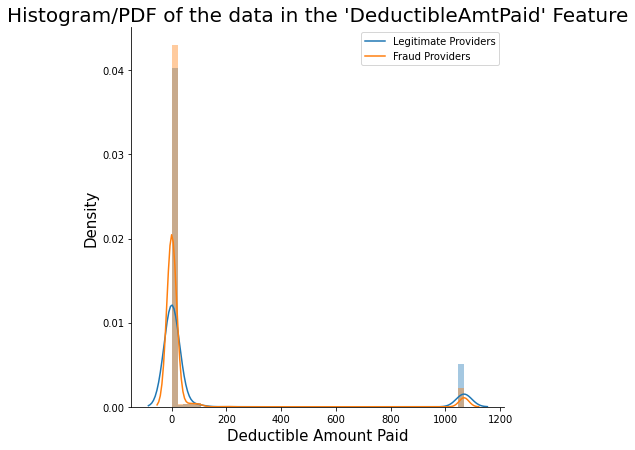

----------------------------------------------------------------------------------------------------------


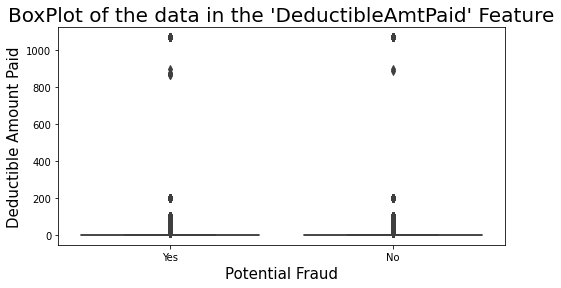

Wall time: 10.9 s


In [ ]:
%%time
# Call the custom function 'plotNumFeat' to plot the Histogram/PDF of the 'DeductibleAmtPaid' feature data.
plotNumFeat(type='Density', data=dataClaim, feature='DeductibleAmtPaid', figureHeight=6,
            title='Histogram/PDF of the data in the \'' + 'DeductibleAmtPaid' + '\' Feature', hue='PotentialFraud',
            xlabel='Deductible Amount Paid', ylabel='Density')

print('----------------------------------------------------------------------------------------------------------')

# Call the custom function 'plotNumFeat' to plot the BoxPlot of the 'DeductibleAmtPaid' feature data
plotNumFeat(type='Box', figsize=(8,4), data=dataClaim, feature='DeductibleAmtPaid',
            title='BoxPlot of the data in the \'' + 'DeductibleAmtPaid' + '\' Feature', hue='PotentialFraud',
            xlabel='Potential Fraud', ylabel='Deductible Amount Paid')

#### Observation from the EDA of 'DeductibleAmtPaid' Feature

* For 'DeductibleAmtPaid' feature, most of the amount values are zero.
* Because of the too many zero values, we see the non-zero values as outliers in the Box Plot.

### <font color="blue">3.3.3. EDA of Claim (Inpatient and Outpatient) Dataset - ClmAdmitDiagnosisCode Feature</font>

In [ ]:
print('No. of unique values of the feature \'ClmAdmitDiagnosisCode\': ', 
      len(dataClaim['ClmAdmitDiagnosisCode'].unique()))

No. of unique values of the feature 'ClmAdmitDiagnosisCode':  4099


* As there are too many categories in the 'ClmAdmitDiagnosisCode' feature, the plot will be overlapped.
* Hence, let's plot the top 50 categories only.

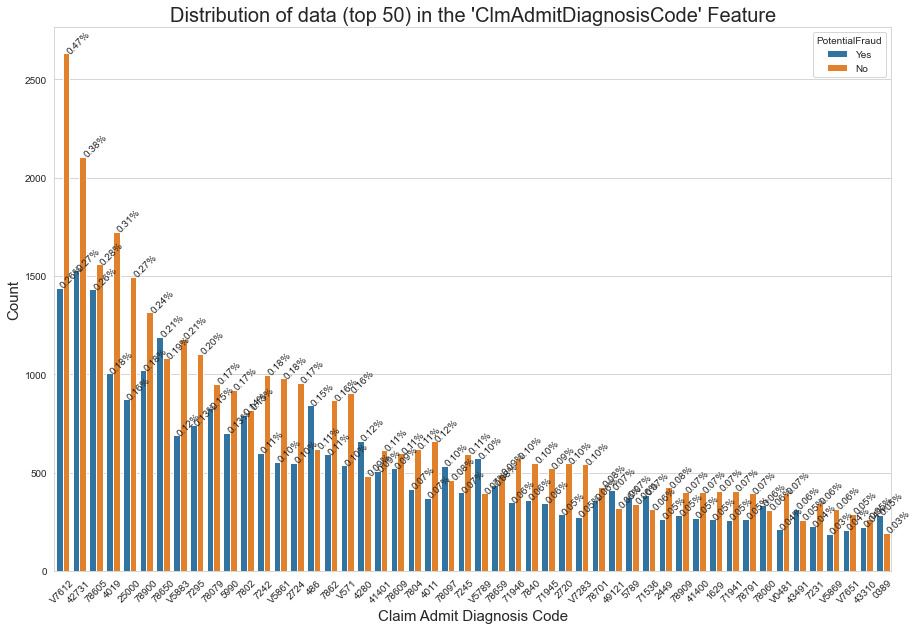

Wall time: 4.53 s


In [ ]:
%%time
# Call the custom function 'countPlot' to plot the Count Plot for the top 50 'ClmAdmitDiagnosisCode' feature
countPlot(figsize=(15,10), title='Distribution of data (top 50) in the \'ClmAdmitDiagnosisCode\' Feature',
          xlabel='Claim Admit Diagnosis Code', ylabel='Count', data=dataClaim, hue='PotentialFraud',
          firstK=50, feature='ClmAdmitDiagnosisCode', annotateRotate=45, xtickRotate=45)

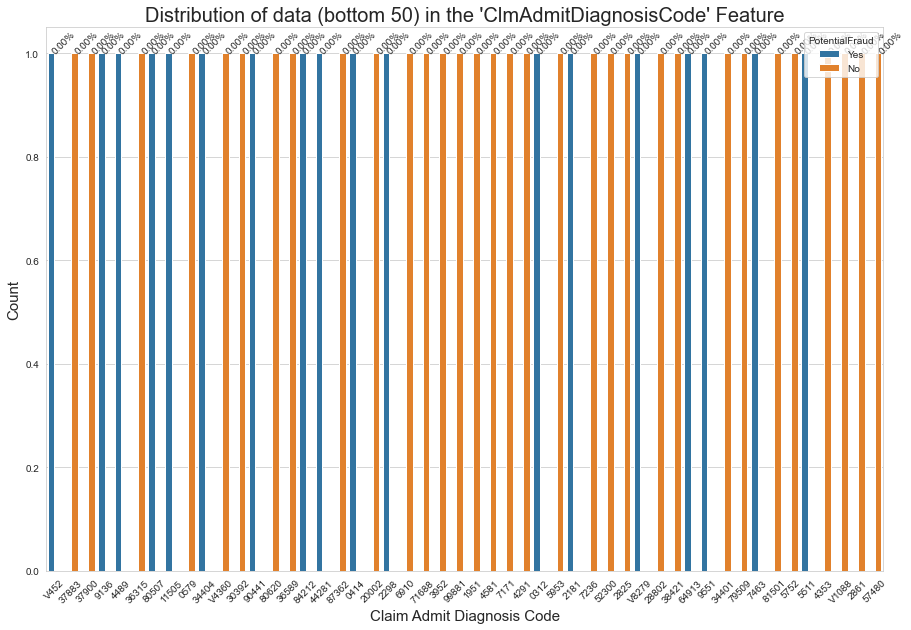

Wall time: 4.67 s


In [ ]:
%%time
# Call the custom function 'countPlot' to plot the Count Plot for the top 50 'ClmAdmitDiagnosisCode' feature
countPlot(figsize=(15,10), title='Distribution of data (bottom 50) in the \'ClmAdmitDiagnosisCode\' Feature',
          xlabel='Claim Admit Diagnosis Code', ylabel='Count', data=dataClaim, hue='PotentialFraud', showTop=False,
          firstK=50, feature='ClmAdmitDiagnosisCode', annotateRotate=45, xtickRotate=45)

In [ ]:
# Show the number of records present for each categories in the 'ClmAdmitDiagnosisCode' feature.
dataClaim['ClmAdmitDiagnosisCode'].value_counts()

V7612    4074
42731    3634
78605    2992
4019     2732
25000    2368
         ... 
40201       1
20380       1
V069        1
72789       1
1620        1
Name: ClmAdmitDiagnosisCode, Length: 4098, dtype: int64

#### Observation from the EDA of the 'ClmAdmitDiagnosisCode' Feature

* From the top 50 categories of 'ClmAdmitDiagnosisCode' feature, we can see that all the codes (categories) are present for both positive (fraud) and negative (non-fraud) cases.
* From the bottom 50 categories of 'ClmAdmitDiagnosisCode' feature, we can see that some codes (categories) are not present for both the classes but are present for either of them. For example, category 'V452' is present only once for fraud case and category '37883' is present only once for non-fraud case.
* We can see from the plot of bottom 50 categories and value_counts() method that there are few codes that occur only once.
* The top 5 Claim Admit Diagonsis Codes are 'V7612', '42731', '78605', '4019' and '25000'.

### <font color="blue">3.3.4. EDA of Claim (Inpatient) Dataset - DiagnosisGroupCode Feature</font>

In [ ]:
print('No. of unique values of the feature \'DiagnosisGroupCode\': ', 
      len(dataClaim['DiagnosisGroupCode'].unique()))

No. of unique values of the feature 'DiagnosisGroupCode':  737


* There are 737 categories and the plot will be very much crowded because of too many categories.
* Let's try to plot the graph for the top 50 and bottom 50 categories.

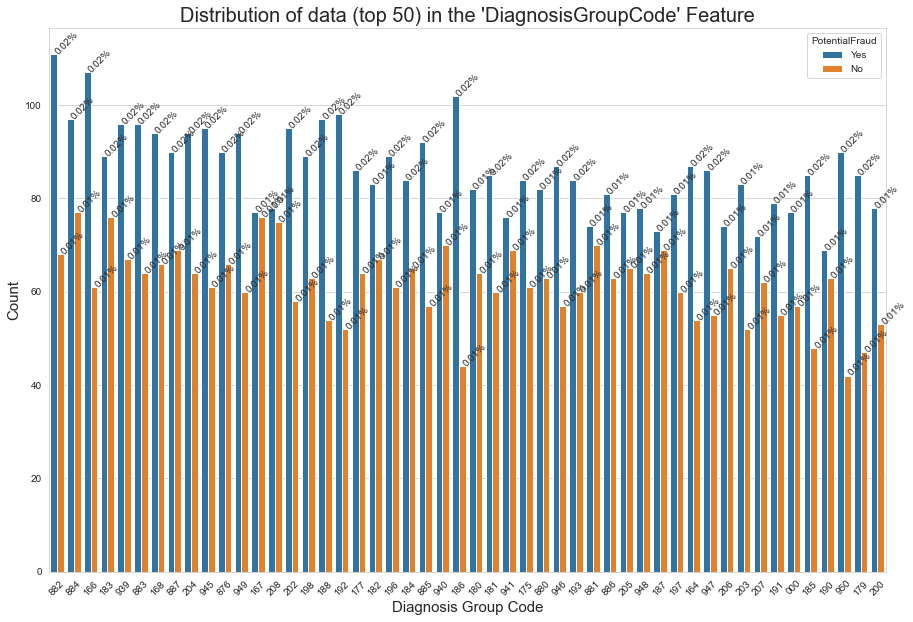

Wall time: 5.75 s


In [ ]:
%%time
# Call the custom function 'countPlot' to plot the Count Plot for the top 50 'DiagnosisGroupCode' feature
countPlot(figsize=(15,10), title='Distribution of data (top 50) in the \'DiagnosisGroupCode\' Feature',
          xlabel='Diagnosis Group Code', ylabel='Count', data=dataClaim, hue='PotentialFraud',
          firstK=50, feature='DiagnosisGroupCode', annotateRotate=45, xtickRotate=45)

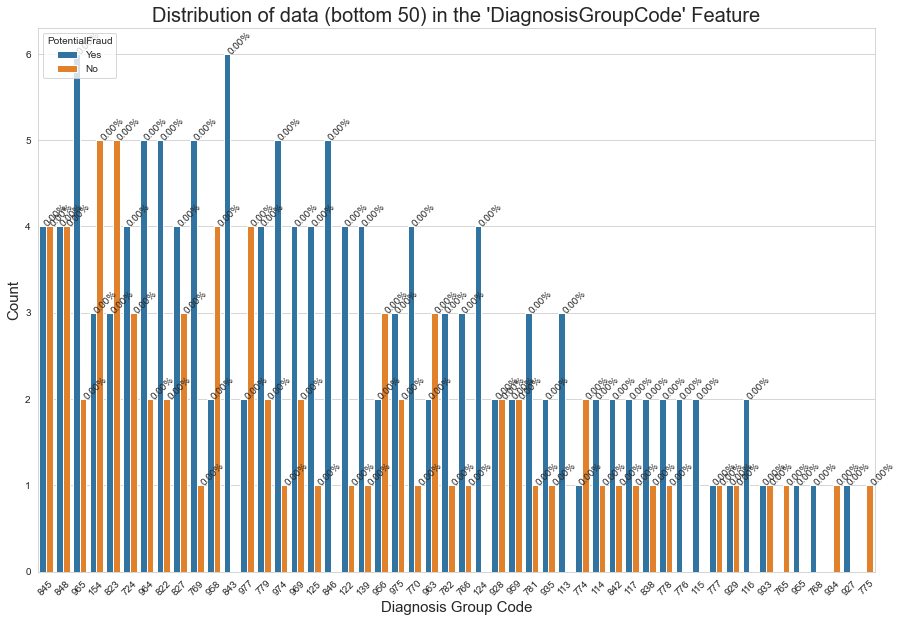

Wall time: 5.46 s


In [ ]:
%%time
# Call the custom function 'countPlot' to plot the Count Plot for the top 50 'DiagnosisGroupCode' feature
countPlot(figsize=(15,10), title='Distribution of data (bottom 50) in the \'DiagnosisGroupCode\' Feature',
          xlabel='Diagnosis Group Code', ylabel='Count', data=dataClaim, hue='PotentialFraud', showTop=False,
          firstK=50, feature='DiagnosisGroupCode', annotateRotate=45, xtickRotate=45)

#### Observation from the EDA of the 'DiagnosisGroupCode' Feature

* From the top 50 categories of 'DiagnosisGroupCode' feature, we cannot deduce much information.
* From the bottom 50 categories of 'DiagnosisGroupCode' feature, we can see that there are few codes that occur only once (Count = 1). In the 'ClmAdmitDiagnosisCode' feature, there are comparatively lot of codes which had only one occurrence.
* We cannot deduce much meaningful insight from this feature.

### <font color="blue">3.3.5. EDA of Claim (Inpatient and Outpatient) Dataset - Claim Diagnosis Codes Features</font>

* Here, we will do the EDA for all the ten Claim Diagnosis Code Features.<br>
&emsp; 1. ClmDiagnosisCode_1: Diagnosis code identifying the beneficiary's principal diagnosis.<br>
&emsp; 2. ClmDiagnosisCode_2-10: Diagnosis code in the 2nd, 3rd and so on, till the 10th position identifying the condition(s) for which the beneficiary is receiving care.<br>

In [ ]:
# Fetch the Claim Diagnosis Code columns
print('Claim Diagnosis Features:\n')
colDiagCode = [col for col in dataClaim.columns if 'ClmDiagnosisCode' in col]
for diagCode in colDiagCode:
    print(diagCode)

Claim Diagnosis Features:

ClmDiagnosisCode_1
ClmDiagnosisCode_2
ClmDiagnosisCode_3
ClmDiagnosisCode_4
ClmDiagnosisCode_5
ClmDiagnosisCode_6
ClmDiagnosisCode_7
ClmDiagnosisCode_8
ClmDiagnosisCode_9
ClmDiagnosisCode_10


In [ ]:
# Display the number of unique values in each of the feature
for diagCode in colDiagCode:
    print('No. of unique values of the feature \'' + diagCode + '\': ', len(dataClaim[diagCode].unique()))

No. of unique values of the feature 'ClmDiagnosisCode_1':  10451
No. of unique values of the feature 'ClmDiagnosisCode_2':  5301
No. of unique values of the feature 'ClmDiagnosisCode_3':  4757
No. of unique values of the feature 'ClmDiagnosisCode_4':  4360
No. of unique values of the feature 'ClmDiagnosisCode_5':  3971
No. of unique values of the feature 'ClmDiagnosisCode_6':  3608
No. of unique values of the feature 'ClmDiagnosisCode_7':  3389
No. of unique values of the feature 'ClmDiagnosisCode_8':  3071
No. of unique values of the feature 'ClmDiagnosisCode_9':  2775
No. of unique values of the feature 'ClmDiagnosisCode_10':  1159


  0%|          | 0/10 [00:00<?, ?it/s]

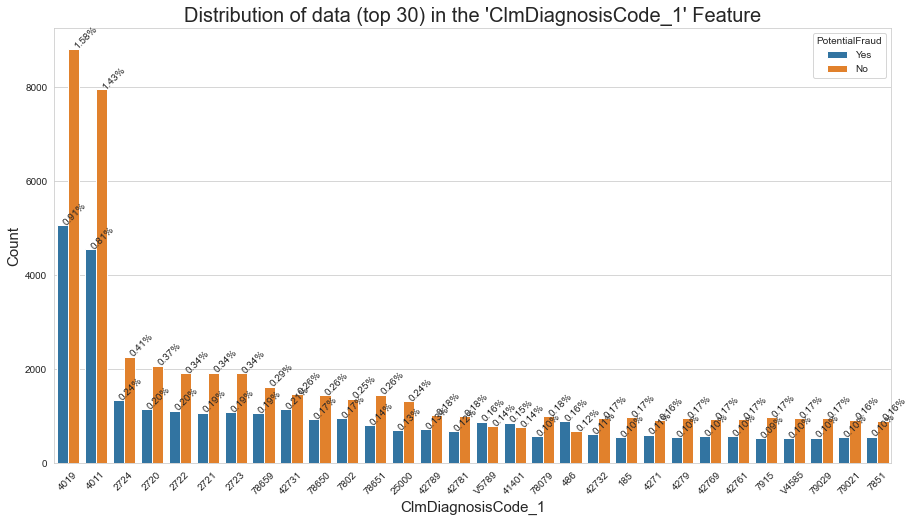

----------------------------------------------------------------------------------------------------------


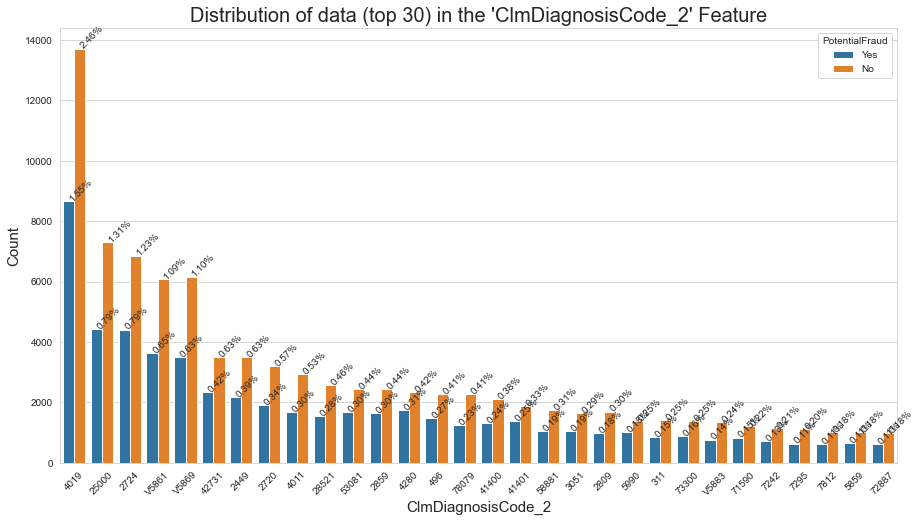

----------------------------------------------------------------------------------------------------------


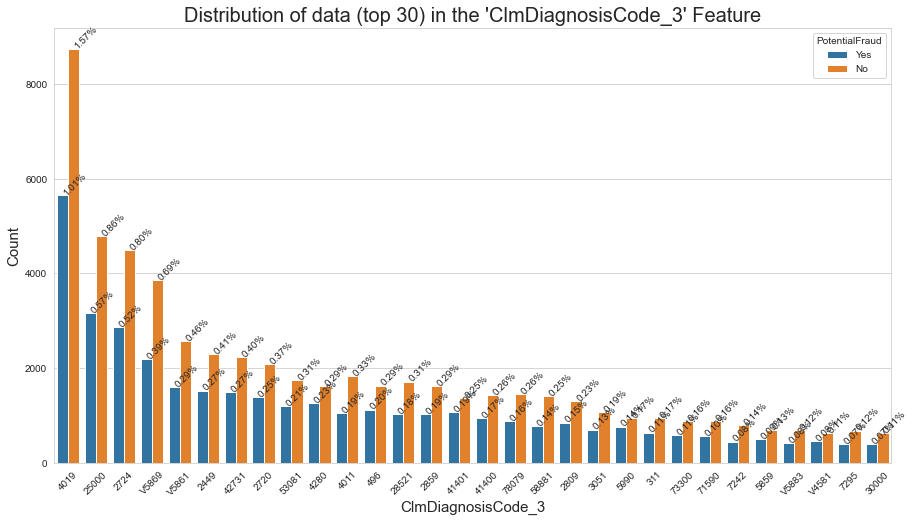

----------------------------------------------------------------------------------------------------------


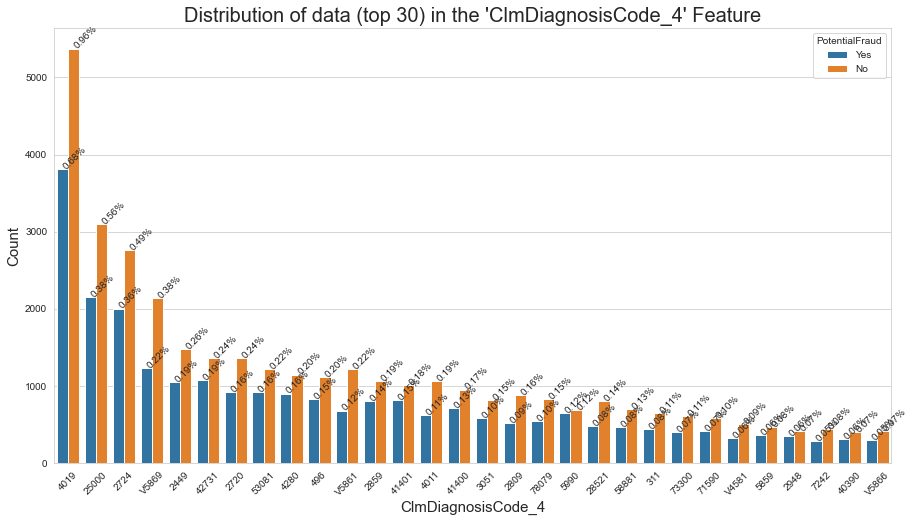

----------------------------------------------------------------------------------------------------------


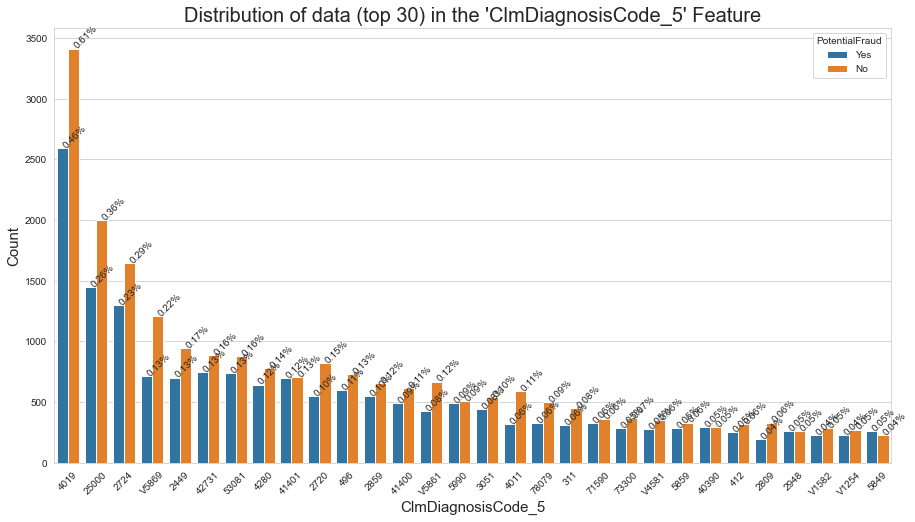

----------------------------------------------------------------------------------------------------------


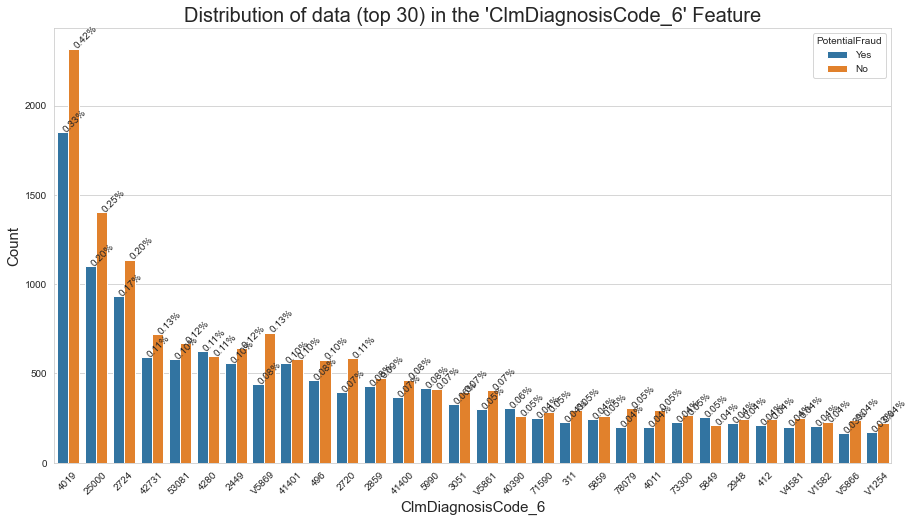

----------------------------------------------------------------------------------------------------------


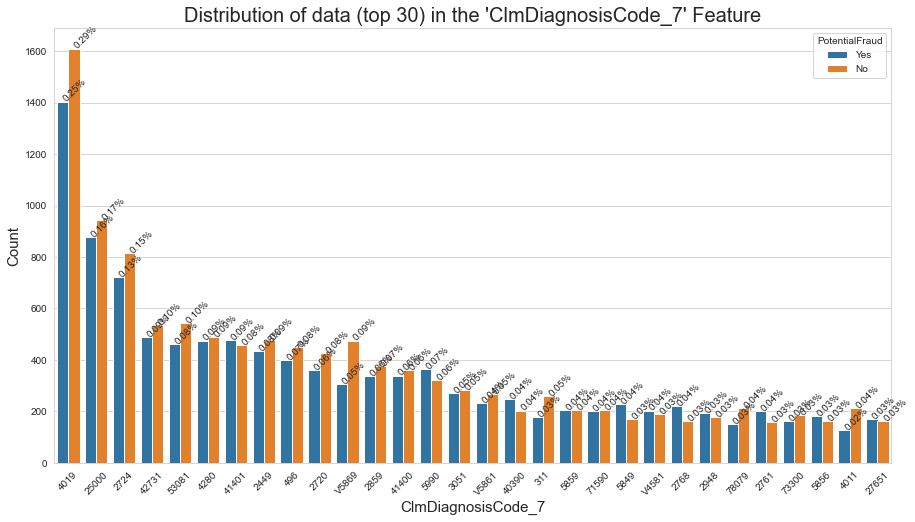

----------------------------------------------------------------------------------------------------------


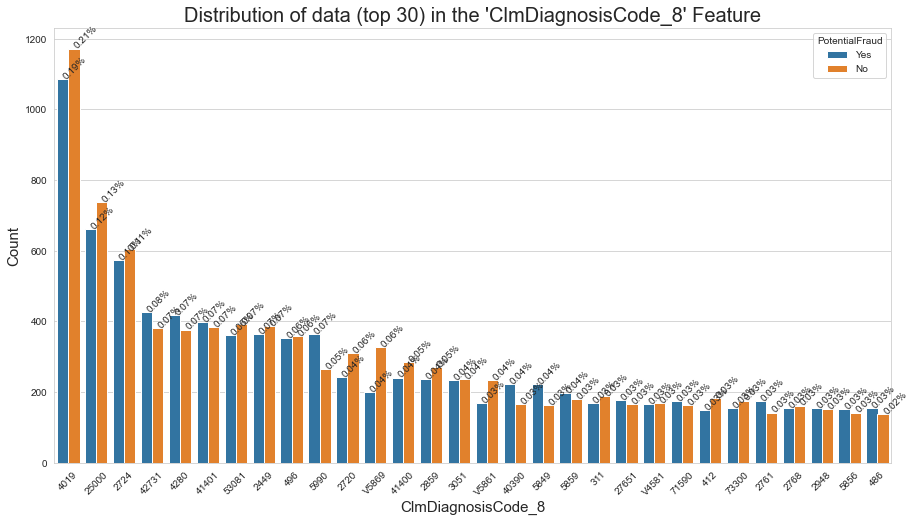

----------------------------------------------------------------------------------------------------------


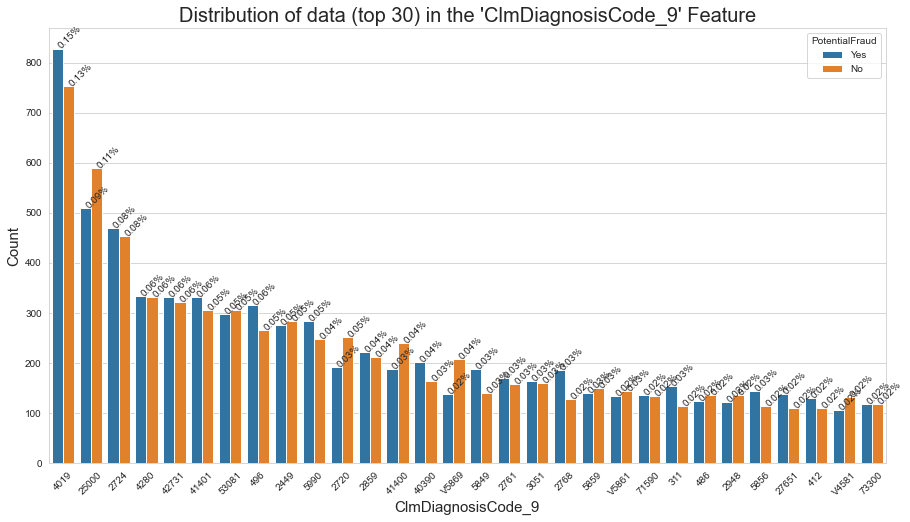

----------------------------------------------------------------------------------------------------------


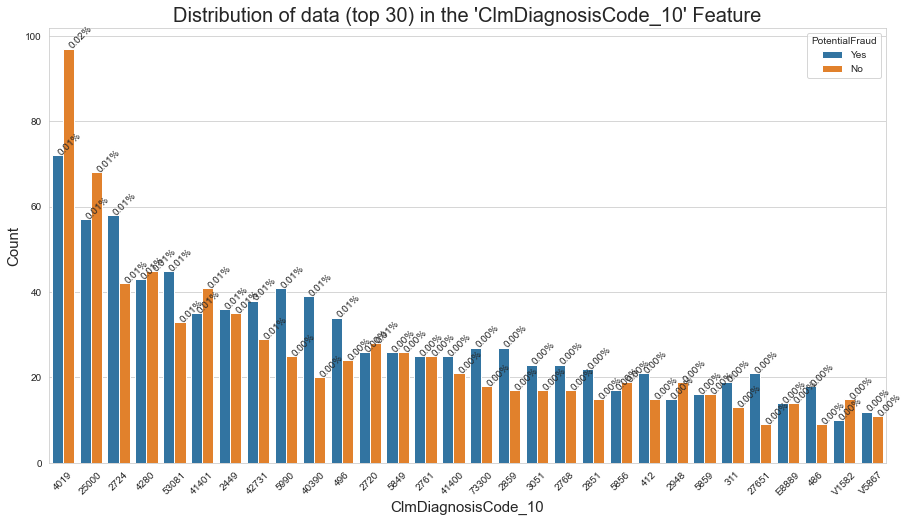

----------------------------------------------------------------------------------------------------------
Wall time: 12.4 s


In [ ]:
%%time
# Call the custom function 'countPlot' to plot the Count Plot for the top 30 categories in each feature
for diagCode in tqdm(colDiagCode):
    countPlot(figsize=(15,8), title='Distribution of data (top 30) in the \'' + diagCode + '\' Feature',
              xlabel=diagCode, ylabel='Count', data=dataClaim, hue='PotentialFraud', 
              firstK=30, feature=diagCode, annotateRotate=45, xtickRotate=45)
    
    print('----------------------------------------------------------------------------------------------------------')

In [ ]:
print('Most occurring codes in all the Claim Diagnosis Features\' top 10 codes, '
      'along with their count across all Features:\n', \
     topKCommonCodes(dataClaim, colDiagCode, 10))

  0%|          | 0/10 [00:00<?, ?it/s]

Most occurring codes in all the Claim Diagnosis Features' top 10 codes, along with their count across all Features:
 {'4019': 10, '2724': 10, '42731': 10, '25000': 9, '2449': 9, '53081': 8, '4280': 8, '2720': 6, '41401': 6, 'V5869': 5}


#### Observation from the EDA of the Claim Diagnosis Codes Features

* In all the Diagnosis Codes, code '4019' has the highest percentage of claims.
* In 'ClmDiagnosisCode_1', the 2nd and 3rd most occurrent codes are '4011' and '2724' respectively.
* In all features except 'ClmDiagnosisCode_1', the 2nd and 3rd most occurrent codes are '25000' and '2724' respectively.
* The codes '4019', '2724' and '42731' occur in all features.

### <font color="blue">3.3.6. EDA of Inpatient Dataset - Claim Procedure Codes Features</font>

* Here, we will do the EDA for all the six Claim Procedure Code Features.
* Claim Procedures Codes indicate the principal or other procedures performed during the period covered by the institutional claim.

In [ ]:
# Fetch the Claim Procedure Code columns
colProcCode = [col for col in dataClaim.columns if 'ClmProcedureCode' in col]

print('Claim Procedure Codes Features:\n')
for procCode in colProcCode:
    print(procCode)

Claim Procedure Codes Features:

ClmProcedureCode_1
ClmProcedureCode_2
ClmProcedureCode_3
ClmProcedureCode_4
ClmProcedureCode_5
ClmProcedureCode_6


In [ ]:
# Display the number of unique values in each of the feature
for procCode in colProcCode:
    print('No. of unique values of the feature \'' + procCode + '\': ', len(dataClaim[procCode].unique()))

No. of unique values of the feature 'ClmProcedureCode_1':  1118
No. of unique values of the feature 'ClmProcedureCode_2':  301
No. of unique values of the feature 'ClmProcedureCode_3':  155
No. of unique values of the feature 'ClmProcedureCode_4':  49
No. of unique values of the feature 'ClmProcedureCode_5':  7
No. of unique values of the feature 'ClmProcedureCode_6':  1


* We can see that there is only one unique value in the 'ClmProcedureCode_6' feature.
* Let print a concise summary of a DataFrame for the Claim Procedure Codes features.

In [ ]:
# Print a detail information of the Claim Procedure columns in the Claim dataframe
dataClaim[colProcCode].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 558211 entries, 0 to 558210
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   ClmProcedureCode_1  23310 non-null  float64
 1   ClmProcedureCode_2  5490 non-null   float64
 2   ClmProcedureCode_3  969 non-null    float64
 3   ClmProcedureCode_4  118 non-null    float64
 4   ClmProcedureCode_5  9 non-null      float64
 5   ClmProcedureCode_6  0 non-null      float64
dtypes: float64(6)
memory usage: 45.9 MB


* As we can see that the 'ClmProcedureCode_6' has all empty values, remove the feature from the dataset.

In [ ]:
dataClaim.drop(columns='ClmProcedureCode_6', inplace=True)

In [ ]:
# Fetch the Claim Procedure Codes' Features after removal of 'ClmProcedureCode_6' feature
colProcCode = [col for col in dataClaim.columns if 'ClmProcedureCode' in col]

  0%|          | 0/5 [00:00<?, ?it/s]

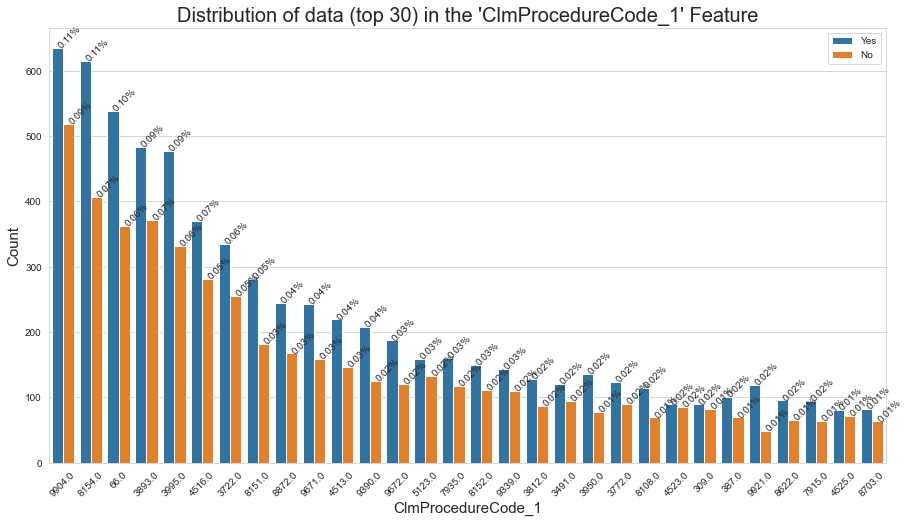

----------------------------------------------------------------------------------------------------------


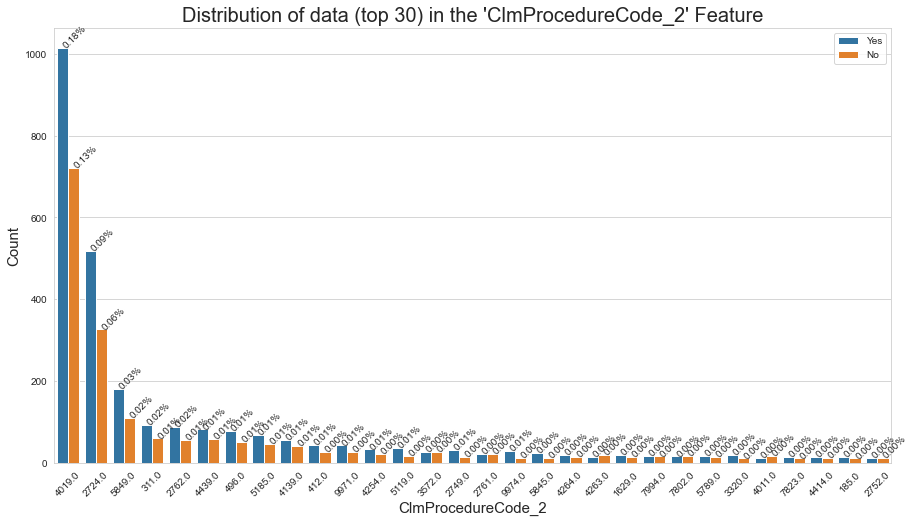

----------------------------------------------------------------------------------------------------------


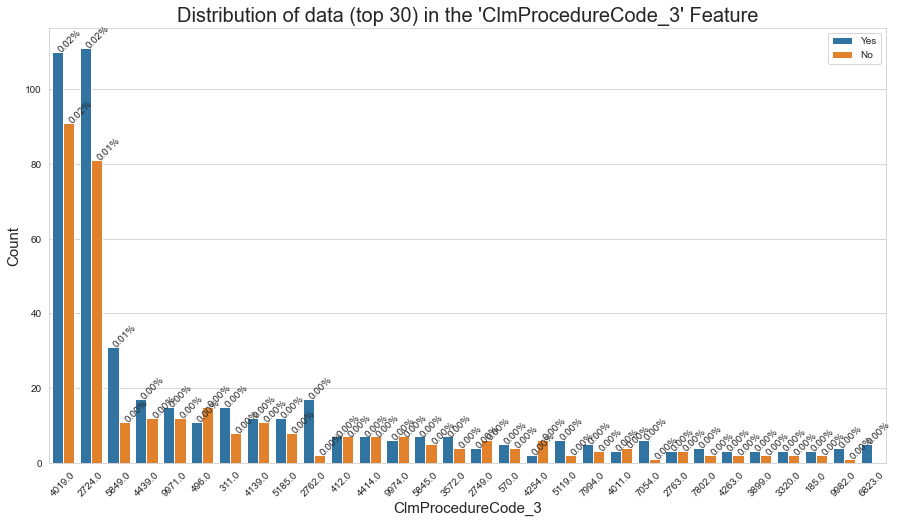

----------------------------------------------------------------------------------------------------------


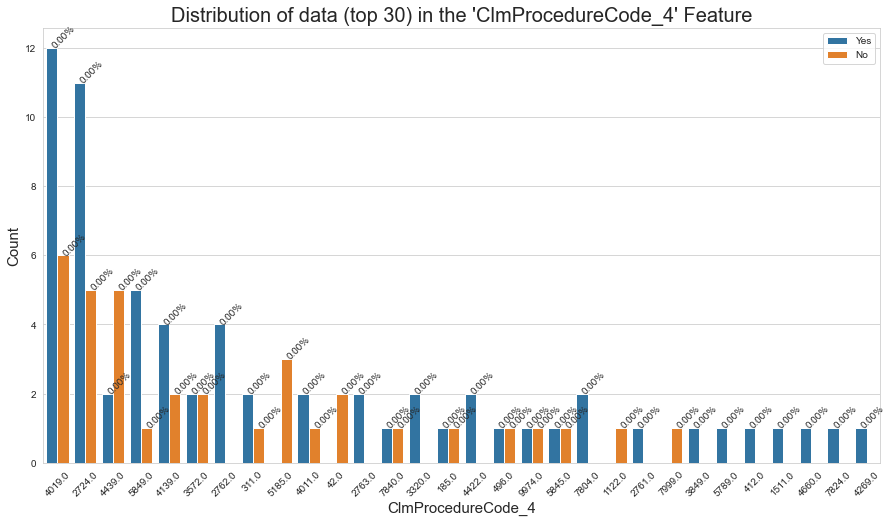

----------------------------------------------------------------------------------------------------------


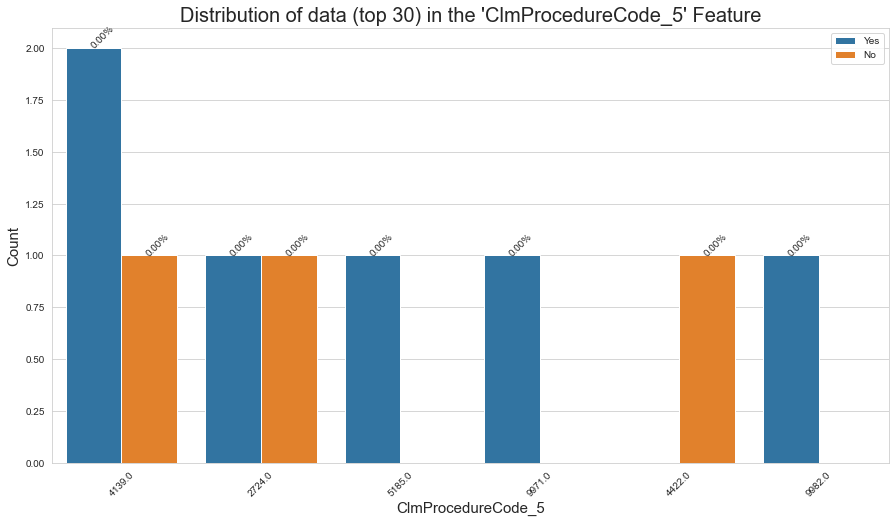

----------------------------------------------------------------------------------------------------------
Wall time: 10 s


In [ ]:
%%time
# Call the custom function 'countPlot' to plot the Count Plot for the top 30 categories in each feature
for procCode in tqdm(colProcCode):
    
    countPlot(figsize=(15,8), title='Distribution of data (top 30) in the \'' + procCode + '\' Feature',
              xlabel=procCode, ylabel='Count', data=dataClaim, hue='PotentialFraud',
              firstK=30, feature=procCode, annotateRotate=45, xtickRotate=45)
    
    print('----------------------------------------------------------------------------------------------------------')

In [ ]:
print('Most occurring codes in all the Claim Procedure Features\' top 10 codes, '
      'along with their count across all Features:\n', \
     topKCommonCodes(dataClaim, colProcCode, 10))

  0%|          | 0/5 [00:00<?, ?it/s]

Most occurring codes in all the Claim Procedure Features' top 10 codes, along with their count across all Features:
 {2724.0: 4, 5185.0: 4, 4139.0: 4, 4019.0: 3, 5849.0: 3, 311.0: 3, 2762.0: 3, 4439.0: 3, 496.0: 2, 9971.0: 2}


#### Observation from the EDA of Claim Procedure Codes Features

* For 'ClmProcedureCode_1', code '9904.0' has the most occurrence, followed by '8154.0', '66.0', '3893.0', '3995' and so on. None of these 5 codes occur in any of the top 10 codes of other 4 features.
* Code '4019.0' is most occurring code in the 3 features 'ClmProcedureCode_2', 'ClmProcedureCode_3' and 'ClmProcedureCode_4'.
* Most common codes in all the 5 features are '2724.0', '5185.0' and '4139.0' with four occurrences.
* Features 'ClmProcedureCode_4' and 'ClmProcedureCode_5' have very negligible (~0%) codes present and can be dropped.

----

### <font color="blue">3.3.7. EDA of Inpatient Dataset - Physician Features</font>

* Here, we will do the EDA on the below features:<br>
&emsp; 1. AttendingPhysician.<br>
&emsp; 2. OperatingPhysician.<br>
&emsp; 3. OtherPhysician.<br>

In [ ]:
colPhys = [feature for feature in dataClaim.columns if 'Physician' in feature]

In [ ]:
print('Physician Features:\n')
for phys in colPhys:
    print(phys)

Physician Features:

AttendingPhysician
OperatingPhysician
OtherPhysician


In [ ]:
# Display the number of unique values in each of the feature
for phys in colPhys:
    print('No. of unique physicians in the feature \'' + phys + '\': ', len(dataClaim[phys].unique()))

No. of unique physicians in the feature 'AttendingPhysician':  82064
No. of unique physicians in the feature 'OperatingPhysician':  35316
No. of unique physicians in the feature 'OtherPhysician':  46458


In [ ]:
# Print a detail information of the Physician columns in the Claim dataframe
dataClaim[colPhys].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 558211 entries, 0 to 558210
Data columns (total 3 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   AttendingPhysician  556703 non-null  object
 1   OperatingPhysician  114447 non-null  object
 2   OtherPhysician      199736 non-null  object
dtypes: object(3)
memory usage: 33.2+ MB


  0%|          | 0/3 [00:00<?, ?it/s]

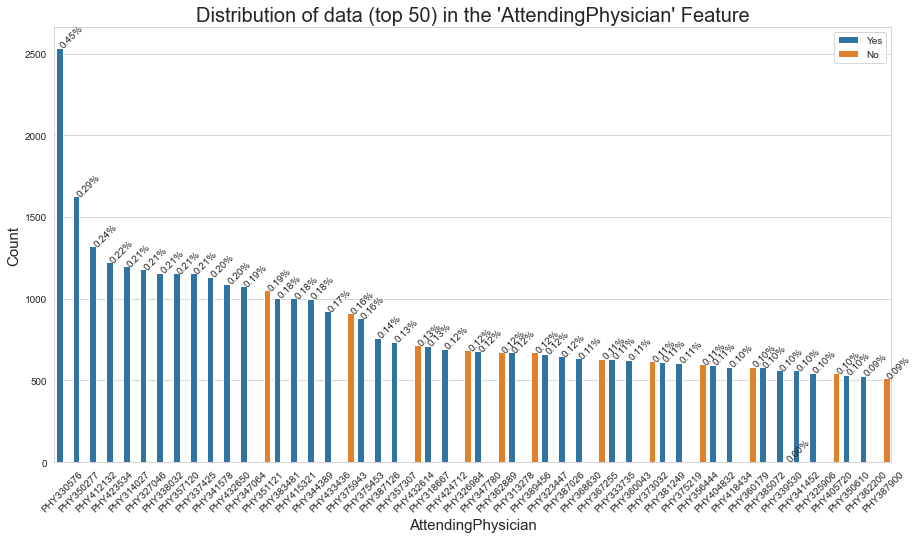

----------------------------------------------------------------------------------------------------------


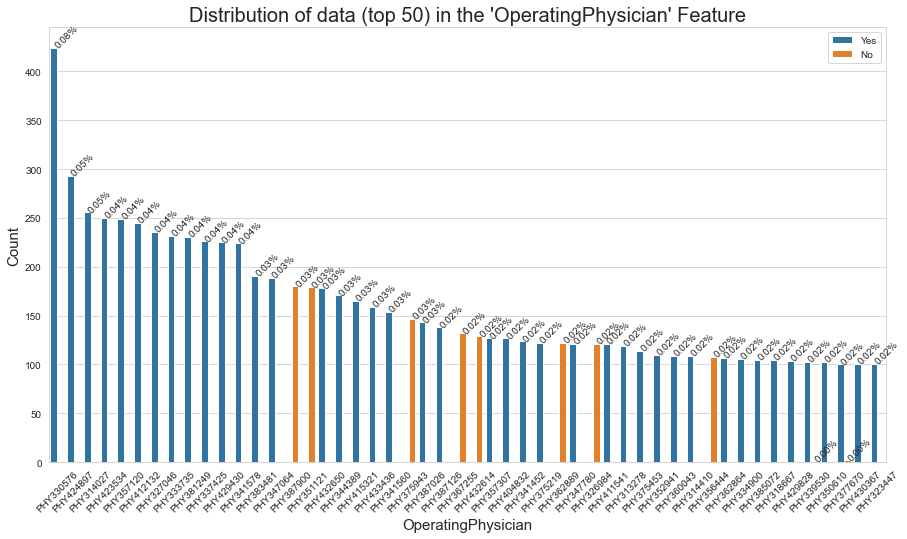

----------------------------------------------------------------------------------------------------------


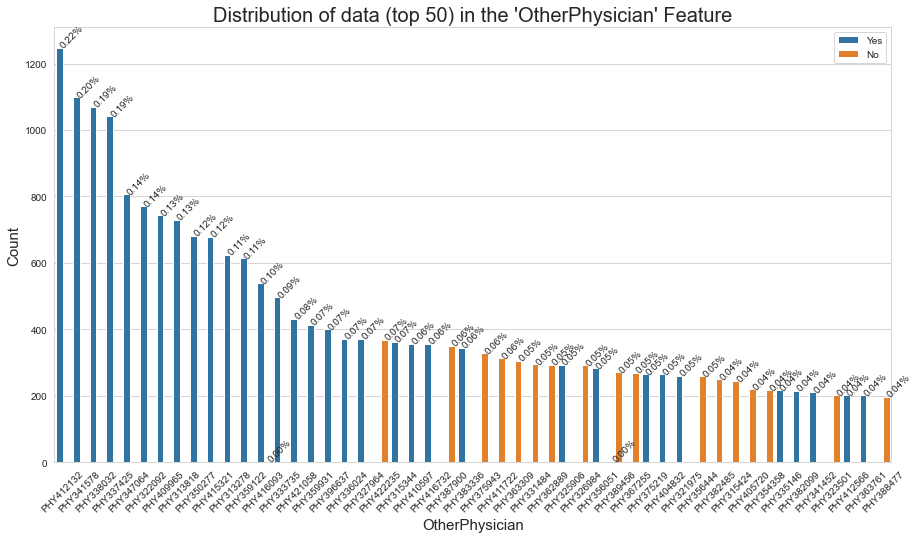

----------------------------------------------------------------------------------------------------------
Wall time: 15.3 s


In [ ]:
%%time
# Call the custom function 'countPlot' to plot the Count Plot for the top 50 Physicians in each feature
for phys in tqdm(colPhys):
    
    countPlot(figsize=(15,8), title='Distribution of data (top 50) in the \'' + phys + '\' Feature',
              xlabel=phys, ylabel='Count', data=dataClaim, hue='PotentialFraud',
              firstK=50, feature=phys, annotateRotate=45, xtickRotate=45)
    
    print('----------------------------------------------------------------------------------------------------------')

In [ ]:
print('Most occurring Physicians in all the Physician related Features\' top 10 physicians, '
      'along with their count across all Features:\n', \
     topKCommonCodes(dataClaim, ['AttendingPhysician', 'OperatingPhysician', 'OtherPhysician'], 10))

  0%|          | 0/3 [00:00<?, ?it/s]

Most occurring Physicians in all the Physician related Features' top 10 physicians, along with their count across all Features:
 {'PHY412132': 3, 'PHY337425': 3, 'PHY330576': 2, 'PHY350277': 2, 'PHY423534': 2, 'PHY314027': 2, 'PHY327046': 2, 'PHY338032': 2, 'PHY357120': 2, 'PHY341578': 2}


#### Observation from the EDA of Physician Features

* In each of the plots of 'AttendingPhysician', 'OperatingPhysician' and 'OtherPhysician', it can be seen that the top Physicians (12+ in number) are involved in fraud cases only.
* Physician 'PHY330576' attended as well as operated most of the patients.
* Around 2500+ patients were attended by the physician 'PHY330576'.
* Around 425 operations were performed by the physician 'PHY330576'.
* Physician 'PHY412132' was an other physician for most of the patients.


----

----